In [1]:
# !pip install wikipedia-api
# !pip install rake-nltk
# !pip install rake-nltk
# !pip install spacy
# !pip install keybert
# !pip install textblob

# !pip install yake
# !python -m spacy download en_core_web_sm
# !pip install matplotlib
# !pip install textdistance
# !pip install beautifulsoup4
# !pip install emoji


In [47]:
import wikipediaapi
from keybert import KeyBERT
from rake_nltk import Rake
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import re
from collections import Counter

# Uncomment this line if you haven't downloaded the NLTK stopwords
# nltk.download('stopwords')

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize KeyBERT model
kw_model = KeyBERT(model="distilbert-base-nli-mean-tokens")

# Function to clean and preprocess text
def preprocess_text(text):
    text = re.sub(r"\[.*?\]", "", text)  # Remove references
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespaces
    return text.strip()

# Function to extract keywords using KeyBERT
def extract_keybert_keywords(text):
    try:
        word_count = len(text.split())
        top_n = max(1, word_count // 10)
        keywords = kw_model.extract_keywords(
            docs=text,
            keyphrase_ngram_range=(1, 3),
            top_n=top_n,
            use_maxsum=False,
        )
        return [kw[0] for kw in keywords]
    except Exception as e:
        print(f"KeyBERT error: {e}")
        return []

# Function to extract keywords using RAKE
def extract_rake_keywords(text):
    rake = Rake()
    rake.extract_keywords_from_text(text)
    return rake.get_ranked_phrases()[:10]

# Function to extract keywords using SpaCy
def extract_spacy_keywords(text):
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks][:10]

# Function to refine keywords
def refine_keywords(content):
    preprocessed_text = preprocess_text(content)

    print("\nExtracting keywords using KeyBERT...")
    keybert_keywords = extract_keybert_keywords(preprocessed_text)

    print("Extracting keywords using RAKE...")
    rake_keywords = extract_rake_keywords(preprocessed_text)

    print("Extracting keywords using SpaCy...")
    spacy_keywords = extract_spacy_keywords(preprocessed_text)

    # Combine and clean keywords
    all_keywords = keybert_keywords + rake_keywords + spacy_keywords
    unique_keywords = list(set(all_keywords))  # Remove duplicates
    return unique_keywords

# Function to fetch Wikipedia page content
def fetch_wikipedia_page(query, word_limit=1000):
    if query.startswith("http"):
        url = query  # Use the full URL if provided
    else:
        base_url = "https://en.wikipedia.org/wiki/"
        formatted_query = query.replace(" ", "_")
        url = base_url + formatted_query

    print(f"Fetching content from: {url}")
    try:
        response = requests.get(url, headers={"User-Agent": "MyWikipediaBot/1.0"})
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        content = []
        for paragraph in soup.find_all("p"):
            text = paragraph.get_text(strip=True)
            if text:
                content.append(text)
        full_text = " ".join(content)
        words = full_text.split()
        return " ".join(words[:word_limit]) if len(words) > word_limit else full_text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the page: {e}")
        return None

# Function to fetch directly connected links from Wikipedia
def fetch_direct_links(query):
    base_url = "https://en.wikipedia.org/wiki/"
    formatted_query = query.replace(" ", "_")
    url = base_url + formatted_query

    print(f"Fetching links from: {url}")
    try:
        response = requests.get(url, headers={"User-Agent": "MyWikipediaBot/1.0"})
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        
        links = []
        link_texts = []
        for paragraph in soup.find_all("p"):  # Focus on paragraphs for meaningful content
            for link in paragraph.find_all("a", href=True):
                href = link['href']
                if href.startswith("/wiki/") and not re.search(r":", href):  # Exclude special pages
                    full_url = urljoin(base_url, href)
                    links.append(full_url)
                    link_texts.append(link.get_text(strip=True))  # Text of the anchor tag
        
        # Remove duplicates by converting to set and back to list
        unique_links = list(set(links))
        unique_link_texts = [link_texts[links.index(link)] for link in unique_links]
        
        return unique_links, unique_link_texts
    except requests.exceptions.RequestException as e:
        print(f"Error fetching links: {e}")
        return [], []
    

#TRY1 - consine/tfidf

# # Function to calculate similarity and filter top links
# def filter_top_links(query, links, link_texts, top_n=10):
#     if not links or not link_texts:
#         print("No links or texts available for filtering.")
#         return []

#     try:
#         vectorizer = TfidfVectorizer()
#         # Combine query with anchor texts into the corpus
#         corpus = [query] + link_texts
#         tfidf_matrix = vectorizer.fit_transform(corpus)

#         # Compute cosine similarity between query (first entry) and anchor texts
#         similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
#         link_similarity = list(zip(links, similarities))

#         # Sort links by similarity in descending order and select top_n
#         sorted_links = sorted(link_similarity, key=lambda x: x[1], reverse=True)[:top_n]
#         return [link for link, _ in sorted_links]
#     except Exception as e:
#         print(f"Error in similarity calculation: {e}")
#         return []


#TRY2- WUPALMER 
# from nltk.corpus import wordnet as wn

# def calculate_wu_palmer_similarity(word1, word2):
#     try:
#         # Get the synsets for the given words
#         synsets1 = wn.synsets(word1)
#         synsets2 = wn.synsets(word2)

#         if not synsets1 or not synsets2:
#             return 0  # Return 0 similarity if no synsets are found

#         # Compute the maximum Wu-Palmer similarity between all synset pairs
#         max_similarity = max(
#             (s1.wup_similarity(s2) or 0) for s1 in synsets1 for s2 in synsets2
#         )
#         return max_similarity
#     except Exception as e:
#         print(f"Error calculating Wu-Palmer similarity: {e}")
#         return 0

# def filter_top_links(query, links, link_texts, top_n=10):
#     if not links or not link_texts:
#         print("No links or texts available for filtering.")
#         return []

#     try:
#         # Compute similarity scores between query and each link text
#         similarities = []
#         for text in link_texts:
#             words_query = query.split()
#             words_text = text.split()
#             # Calculate average Wu-Palmer similarity for all word pairs
#             similarity = sum(
#                 calculate_wu_palmer_similarity(w1, w2)
#                 for w1 in words_query
#                 for w2 in words_text
#             ) / (len(words_query) * len(words_text))
#             similarities.append(similarity)

#         link_similarity = list(zip(links, similarities))

#         # Sort links by similarity in descending order and select top_n
#         sorted_links = sorted(link_similarity, key=lambda x: x[1], reverse=True)[:top_n]
#         return [link for link, _ in sorted_links]
#     except Exception as e:
#         print(f"Error in similarity calculation: {e}")
#         return []

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet as wn

def calculate_wu_palmer_similarity(word1, word2):
    try:
        # Get the synsets for the given words
        synsets1 = wn.synsets(word1)
        synsets2 = wn.synsets(word2)

        if not synsets1 or not synsets2:
            return 0  # Return 0 similarity if no synsets are found

        # Compute the maximum Wu-Palmer similarity between all synset pairs
        max_similarity = max(
            (s1.wup_similarity(s2) or 0) for s1 in synsets1 for s2 in synsets2
        )
        return max_similarity
    except Exception as e:
        print(f"Error calculating Wu-Palmer similarity: {e}")
        return 0

def calculate_combined_similarity(query, text, cosine_weight=0.8, semantic_weight=0.2):
    # Calculate cosine similarity
    vectorizer = TfidfVectorizer()
    corpus = [query, text]
    tfidf_matrix = vectorizer.fit_transform(corpus)
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()[0]

    # Calculate semantic similarity
    words_query = query.split()
    words_text = text.split()
    if words_query and words_text:
        semantic_sim = sum(
            calculate_wu_palmer_similarity(w1, w2)
            for w1 in words_query
            for w2 in words_text
        ) / (len(words_query) * len(words_text))
    else:
        semantic_sim = 0

    # Combine the two scores
    combined_score = (cosine_weight * cosine_sim) + (semantic_weight * semantic_sim)
    return combined_score




#filter_top_links function
def filter_top_links(query, links, link_texts, top_n=10):
    if not links or not link_texts:
        print("No links or texts available for filtering.")
        return []

    try:
        # Compute combined similarity scores for each link
        similarities = [
            calculate_combined_similarity(query, text)
            for text in link_texts
        ]
        link_similarity = list(zip(links, link_texts, similarities))  # Include link text in tuple

        # Sort links by combined similarity in descending order and select top_n
        sorted_links = sorted(link_similarity, key=lambda x: x[2], reverse=True)[:top_n]

        # Return the sorted links (top 15)
        return [link for link, _, _ in sorted_links]
    except Exception as e:
        print(f"Error in similarity calculation: {e}")
        return []
    

# Main function to fetch keywords
def fetch_and_extract_keywords(query):
    main_content = fetch_wikipedia_page(query)
    if not main_content:
        print("No content fetched for the main page.")
        return []

    print("\nExtracting keywords from the main page...")
    keywords_list = refine_keywords(main_content)

    outlinks, link_texts = fetch_direct_links(query)
    top_links = filter_top_links(query, outlinks, link_texts)



    for idx, link in enumerate(top_links):
        try:
            print(f"\nProcessing outlink {idx + 1}/{len(top_links)}: {link}")
            linked_content = fetch_wikipedia_page(link.split("/")[-1])
            if linked_content:
                print(f"Extracting keywords from: {link}")
                keywords_list.extend(refine_keywords(linked_content))
        except Exception as e:
            print(f"Error processing outlink {link}: {e}")

    return list(set(keywords_list))  # Return unique keywords

# Entry point
if __name__ == "__main__":
    query_keyword = input("Enter the keyword to search in Wikipedia: ")
    

    print(f"Input Keyword: {query_keyword}")
    final_keywords = fetch_and_extract_keywords(query_keyword)
    print("\nFinal Keywords:")
    
    print(final_keywords)

Input Keyword: machine learning
Fetching content from: https://en.wikipedia.org/wiki/machine_learning

Extracting keywords from the main page...

Extracting keywords using KeyBERT...
Extracting keywords using RAKE...
Extracting keywords using SpaCy...
Fetching links from: https://en.wikipedia.org/wiki/machine_learning

Processing outlink 1/10: https://en.wikipedia.org/wiki/Unsupervised_machine_learning
Fetching content from: https://en.wikipedia.org/wiki/Unsupervised_machine_learning
Extracting keywords from: https://en.wikipedia.org/wiki/Unsupervised_machine_learning

Extracting keywords using KeyBERT...
Extracting keywords using RAKE...
Extracting keywords using SpaCy...

Processing outlink 2/10: https://en.wikipedia.org/wiki/Adversarial_machine_learning
Fetching content from: https://en.wikipedia.org/wiki/Adversarial_machine_learning
Extracting keywords from: https://en.wikipedia.org/wiki/Adversarial_machine_learning

Extracting keywords using KeyBERT...
Extracting keywords using RA

In [48]:
len(final_keywords)

981

In [49]:
def split_into_keywords(keywords):
    split_keywords = []
    for keyword in keywords:
        words = keyword.split()  # Split the string by space
        split_keywords.extend(words)  # Add all words to the list
    return split_keywords


preprocessed_keywords = split_into_keywords(final_keywords)
print(preprocessed_keywords)


['goal', 'robots', 'learn', 'researchinformation', 'theorysimulationbased', 'computer', 'experiments', 'including', 'processingcomputer', 'visionspeech', 'networks', 'mostlyperceptronsandother', 'modelsthat', 'fool', 'deep', 'learning', 'algorithmsothers3d', 'printeda', 'toy', 'turtle', 'ethics', 'edited', 'michael', 'statevalue', 'functionvπsdisplaystyle', 'v_pi', 'sis', 'defined', 'asexpected', 'discounted', 'returnstarting', 'includinghopfieldwidrowandnarendraand', 'popularized', 'surveys', 'a', 'human', 'user', 'which', 'computing', 'machinery', 'intelligence', 'algorithms', 'studied', 'obfuscating', 'malware', 'code', 'withinnetwork', 'packetsor', 'modifying', 'estimationinstatisticsthough', 'unsupervised', 'learning', 'mindphilosophy', 'science', 'andlogic', 'reduction', 'dynamical', 'manifolds', 'variables', 'instance', 'nonlinear', 'mislead', 'intrusion', 'detectionattacks', 'The', 'field', 'a', 'part', 'the', 'attacks', 'closely', 'related', 'toadaptive', 'controlreinforcement

In [50]:
len(preprocessed_keywords)

3199

In [51]:
from nltk.corpus import words
import nltk

# Ensure the words corpus is downloaded
nltk.download('words')

word_list = set(words.words())

def split_compound_words(keywords):
    def split_word(word):
        # If the word itself is valid, return it
        if word in word_list:
            return [word]
        
        # Otherwise, try to split it
        for i in range(len(word), 0, -1):  # Start from the longest possible split
            prefix = word[:i]
            suffix = word[i:]
            if prefix in word_list:
                return [prefix] + split_word(suffix)
        
        # If no valid split is found, return the word itself
        return [word]

    split_keywords = []
    for keyword in keywords:
        split_keywords.extend(split_word(keyword))
    return split_keywords

split_keywords = split_compound_words(preprocessed_keywords)
print(split_keywords)
preprocessed_keywords = split_compound_words(preprocessed_keywords)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bhumi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


['goal', 'robot', 's', 'learn', 'research', 'information', 'theory', 'simulation', 'based', 'computer', 'experiment', 's', 'in', 'c', 'l', 'u', 'ding', 'process', 'ing', 'computer', 'vision', 'speech', 'network', 's', 'mostly', 'percept', 'r', 'ons', 'and', 'other', 'model', 'st', 'hat', 'fool', 'deep', 'learning', 'algorithm', 'sot', 'hers', '3d', 'printed', 'a', 'toy', 'turtle', 'ethics', 'edit', 'e', 'd', 'mi', 'cha', 'el', 'state', 'value', 'function', 'v', 'πsdisplaystyle', 'v', '_pi', 'sis', 'defined', 'ase', 'x', 'p', 'e', 'c', 'ted', 'discount', 'e', 'd', 'return', 'starting', 'in', 'c', 'l', 'u', 'ding', 'hop', 'field', 'wid', 'rowan', 'd', 'nar', 'end', 'ra', 'and', 'popularize', 'd', 'survey', 's', 'a', 'human', 'user', 'which', 'c', 'om', 'put', 'ing', 'machinery', 'intelligence', 'algorithm', 's', 'studied', 'o', 'b', 'fusc', 'at', 'ing', 'mal', 'ware', 'code', 'within', 'network', 'packet', 'so', 'r', 'modify', 'ing', 'estimation', 'in', 'statistics', 'though', 'unsupervi

In [52]:
len(preprocessed_keywords)

6244

In [53]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Define the stop_words set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from keywords
def remove_stopwords(keywords):
    return [word for word in keywords if word.lower() not in stop_words]


filtered_keywords = remove_stopwords(preprocessed_keywords)
print(filtered_keywords)


['goal', 'robot', 'learn', 'research', 'information', 'theory', 'simulation', 'based', 'computer', 'experiment', 'c', 'l', 'u', 'ding', 'process', 'ing', 'computer', 'vision', 'speech', 'network', 'mostly', 'percept', 'r', 'ons', 'model', 'st', 'hat', 'fool', 'deep', 'learning', 'algorithm', 'sot', '3d', 'printed', 'toy', 'turtle', 'ethics', 'edit', 'e', 'mi', 'cha', 'el', 'state', 'value', 'function', 'v', 'πsdisplaystyle', 'v', '_pi', 'sis', 'defined', 'ase', 'x', 'p', 'e', 'c', 'ted', 'discount', 'e', 'return', 'starting', 'c', 'l', 'u', 'ding', 'hop', 'field', 'wid', 'rowan', 'nar', 'end', 'ra', 'popularize', 'survey', 'human', 'user', 'c', 'om', 'put', 'ing', 'machinery', 'intelligence', 'algorithm', 'studied', 'b', 'fusc', 'ing', 'mal', 'ware', 'code', 'within', 'network', 'packet', 'r', 'modify', 'ing', 'estimation', 'statistics', 'though', 'unsupervised', 'learning', 'mind', 'philosophy', 'science', 'logic', 'reduction', 'dynamical', 'manifold', 'variable', 'instance', 'nonline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhumi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
def filter_short_words(keywords):
    # Filter out words that are 1 or 2 characters long
    return [word for word in keywords if len(word) > 2]


filtered_keywords = filter_short_words(filtered_keywords)
print(filtered_keywords)

['goal', 'robot', 'learn', 'research', 'information', 'theory', 'simulation', 'based', 'computer', 'experiment', 'ding', 'process', 'ing', 'computer', 'vision', 'speech', 'network', 'mostly', 'percept', 'ons', 'model', 'hat', 'fool', 'deep', 'learning', 'algorithm', 'sot', 'printed', 'toy', 'turtle', 'ethics', 'edit', 'cha', 'state', 'value', 'function', 'πsdisplaystyle', '_pi', 'sis', 'defined', 'ase', 'ted', 'discount', 'return', 'starting', 'ding', 'hop', 'field', 'wid', 'rowan', 'nar', 'end', 'popularize', 'survey', 'human', 'user', 'put', 'ing', 'machinery', 'intelligence', 'algorithm', 'studied', 'fusc', 'ing', 'mal', 'ware', 'code', 'within', 'network', 'packet', 'modify', 'ing', 'estimation', 'statistics', 'though', 'unsupervised', 'learning', 'mind', 'philosophy', 'science', 'logic', 'reduction', 'dynamical', 'manifold', 'variable', 'instance', 'nonlinear', 'mislead', 'intrusion', 'detection', 'attack', 'field', 'part', 'attack', 'closely', 'related', 'toad', 'apt', 'control',

In [55]:

filtered_keywords = [item.lower() for item in filtered_keywords]

In [56]:
def remove_duplicates(keywords):
    return list(set(keywords))

filtered_keywords=remove_duplicates(filtered_keywords)

In [57]:
len(filtered_keywords)

947

In [58]:
print(filtered_keywords)

['biological', 'experiment', 'man', 'defined', 'learning', 'development', 'medicine', 'disrupt', 'cab', 'net', 'agent', 'fundamentally', 'rod', 'sac', 'graham', 'thema', 'mid', 'optimal', 'credit', 'yes', 'spirit', 'experience', 'listed', 'model', 'imitation', 'paper', 'soft', 'transform', 'ree', 'tst', 'stock', 'inform', 'reduced', 'style', 'backgammon', 'commercially', 'adjective', 'pee', 'layer', 'powerful', 'approach', 'list', 'typically', 'ted', 'constraint', 'autonomous', 'subman', 'hone', 'generality', 'propositional', 'cheaply', 'signal', 'els', 'propagation', 'assume', 'exist', 'harvest', 'employ', 'considered', 'gan', 'inject', 'portion', 'filter', 'language', 'evolve', 'within', 'repository', 'fabricate', 'peek', 'reach', 'cluster', 'psi', 'genetic', 'aim', 'harder', '1εdisplaystyle', 'call', 'φxdisplaystyle', 'tack', 'seeming', 'rowan', 'purpose', 'borrow', 'old', 'among', 'maximum', 'machinery', 'approximation', 'per', 'radiance', 'stem', 'function', 'phase', 'oisin', 'ray

In [59]:
print(query_keyword)

machine learning


In [60]:
# import json
# from itertools import islice
# from nltk.corpus import wordnet as wn
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from nltk.corpus import stopwords
# from nltk.metrics import edit_distance
# from difflib import SequenceMatcher
# from sentence_transformers import SentenceTransformer
# import numpy as np

# # Pre-trained SentenceTransformer model
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Wu-Palmer similarity
# def wu_palmer_similarity(word1, word2):
#     syn1 = wn.synsets(word1, pos=wn.NOUN)
#     syn2 = wn.synsets(word2, pos=wn.NOUN)
#     if syn1 and syn2:
#         return max((s1.wup_similarity(s2) or 0) for s1 in syn1[:2] for s2 in syn2[:2])
#     return 0

# # Cosine similarity using TF-IDF
# def compute_cosine_similarity(query, keywords):
#     vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=10000)
#     vectors = vectorizer.fit_transform([query] + keywords)
#     return cosine_similarity(vectors[0:1], vectors[1:]).flatten()

# # Semantic similarity using SequenceMatcher
# def semantic_similarity(word1, word2):
#     return SequenceMatcher(None, word1, word2).ratio()

# # Jaccard similarity
# def jaccard_similarity(word1, word2):
#     set1, set2 = set(word1), set(word2)
#     intersection = set1 & set2
#     union = set1 | set2
#     return len(intersection) / len(union) if union else 0

# # Levenshtein similarity
# def levenshtein_similarity(word1, word2):
#     max_len = max(len(word1), len(word2))
#     return 1 - (edit_distance(word1, word2) / max_len) if max_len > 0 else 0

# # Sentence Transformer similarity
# def sentence_transformer_similarity(query, keywords):
#     embeddings = model.encode([query] + keywords)
#     query_embedding = embeddings[0]
#     keyword_embeddings = embeddings[1:]
#     return cosine_similarity([query_embedding], keyword_embeddings).flatten()

# # Batch processing
# def batch_process(iterable, batch_size):
#     it = iter(iterable)
#     while batch := list(islice(it, batch_size)):
#         yield batch

# # Calculate and sort similarities
# def calculate_and_sort_similarities(query_keyword, filtered_keywords):
#     similarities = []
#     cosine_scores = compute_cosine_similarity(query_keyword, filtered_keywords)
#     bert_scores = sentence_transformer_similarity(query_keyword, filtered_keywords)

#     for keyword in filtered_keywords:
#         wu_palmer_sim = wu_palmer_similarity(query_keyword, keyword)
#         semantic_sim = semantic_similarity(query_keyword, keyword)
#         jaccard_sim = jaccard_similarity(query_keyword, keyword)
#         levenshtein_sim = levenshtein_similarity(query_keyword, keyword)
#         cos_sim = cosine_scores[filtered_keywords.index(keyword)]
#         bert_sim = bert_scores[filtered_keywords.index(keyword)]

#         avg_score = (
#             cos_sim + wu_palmer_sim + semantic_sim +
#             jaccard_sim + levenshtein_sim + bert_sim
#         ) / 6

#         similarities.append((keyword, avg_score))

#     similarities.sort(key=lambda x: x[1], reverse=True)
#     return [kw for kw, _ in similarities[:100]]





# # Calculate similarities and get the top 100 keywords
# top_keywords = calculate_and_sort_similarities(query_keyword, filtered_keywords)

# print("Top 100 Keywords:", top_keywords)
# # Save filtered_keywords to a JSON file for the next code snippet
# with open("filtered_keywords.json", "w", encoding="utf-8") as f:
#     json.dump(filtered_keywords, f, indent=4, ensure_ascii=False)

# print("Filtered keywords saved to 'filtered_keywords.json'.")



In [61]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# BERT-based similarity
def sentence_transformer_similarity(query, keywords):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings = model.encode([query] + keywords)
    return cosine_similarity([embeddings[0]], embeddings[1:]).flatten()

# Calculate and sort similarities
def calculate_and_sort_similarities(query_keyword, filtered_keywords):
    # Compute BERT similarity for all keywords
    bert_scores = sentence_transformer_similarity(query_keyword, filtered_keywords)

    # Store results
    results = {"BERT Similarity (SentenceTransformer)": []}

    for keyword, bert_sim in zip(filtered_keywords, bert_scores):
        results["BERT Similarity (SentenceTransformer)"].append((keyword, bert_sim))

    # Sort results by score
    results["BERT Similarity (SentenceTransformer)"].sort(key=lambda x: x[1], reverse=True)

    # Print the top 10 keywords
    print("\n--- Top Keywords by BERT Similarity ---")
    for keyword, score in results["BERT Similarity (SentenceTransformer)"][:10]:
        print(f"{keyword} (Score: {score:.4f})")

    # Return top 100 keywords by BERT similarity
    return [kw for kw, _ in results["BERT Similarity (SentenceTransformer)"][:100]]



# Compute and display results
top_keywords = calculate_and_sort_similarities(query_keyword, filtered_keywords)
print("\nTop 100 Keywords by BERT Similarity:", top_keywords)



--- Top Keywords by BERT Similarity ---
learning (Score: 0.6857)
intelligent (Score: 0.5646)
intelligence (Score: 0.5283)
classification (Score: 0.4936)
recognition (Score: 0.4816)
computational (Score: 0.4598)
analytics (Score: 0.4580)
expert (Score: 0.4573)
artificial (Score: 0.4554)
clever (Score: 0.4538)

Top 100 Keywords by BERT Similarity: ['learning', 'intelligent', 'intelligence', 'classification', 'recognition', 'computational', 'analytics', 'expert', 'artificial', 'clever', 'learner', 'machine', 'algorithm', 'probabilistic', 'knowledge', 'neural', 'instruction', 'skill', 'learn', 'predict', 'pretraining', 'adaptively', 'adaptive', 'model', 'trained', 'automatic', 'optimization', 'interactive', 'training', 'generative', 'autonomous', 'robot', 'identification', 'automatically', 'based', 'information', 'analyze', 'computation', 'ail', 'regression', 'categorization', 'data', 'gradient', 'analysis', 'research', 'inference', 'classifier', 'reinforcement', 'clustering', 'manually',

In [62]:
import json
import os


# Print the list to verify contents
print("Top Keywords:", top_keywords)

# Define the file name
file_name = "filtered_keywords.json"

# Save the list to a JSON file
with open(file_name, "w", encoding="utf-8") as f:
    json.dump(top_keywords, f, indent=4, ensure_ascii=False)

# Get the absolute path of the file
file_path = os.path.abspath(file_name)

# Print the file path
print(f"Filtered keywords saved to: {file_path}")


Top Keywords: ['learning', 'intelligent', 'intelligence', 'classification', 'recognition', 'computational', 'analytics', 'expert', 'artificial', 'clever', 'learner', 'machine', 'algorithm', 'probabilistic', 'knowledge', 'neural', 'instruction', 'skill', 'learn', 'predict', 'pretraining', 'adaptively', 'adaptive', 'model', 'trained', 'automatic', 'optimization', 'interactive', 'training', 'generative', 'autonomous', 'robot', 'identification', 'automatically', 'based', 'information', 'analyze', 'computation', 'ail', 'regression', 'categorization', 'data', 'gradient', 'analysis', 'research', 'inference', 'classifier', 'reinforcement', 'clustering', 'manually', 'sensorimotor', 'imitation', 'experiment', 'detection', 'technology', 'generalization', 'simulation', 'teaching', 'heuristic', 'designing', 'biometric', 'technique', 'researcher', 'experimental', 'machinery', 'making', 'cognitive', 'iterative', 'tech', 'reasoning', 'approach', 'challenge', 'mathematical', 'vector', 'strategi', 'iden

In [35]:
pip install python-louvain

In [36]:
pip install neo4j


Note: you may need to restart the kernel to use updated packages.


In [63]:
!pip install sentence-transformers 
!pip install spacy  
!pip install neo4j 
!pip install python-louvain  
!pip install numpy  


In [64]:
import json
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import spacy
from neo4j import GraphDatabase
from pyphen import Pyphen

# Initialize tools
model = SentenceTransformer('all-MiniLM-L6-v2')  # Sentence Transformer
nlp = spacy.load("en_core_web_sm")  # spaCy model
dic = Pyphen(lang='en')

# Neo4j connection setup
uri = "bolt://localhost:7687"  
username = "neo4j"
password = "akashbhumi"  
driver = None

try:
    driver = GraphDatabase.driver(uri, auth=(username, password))
    driver.verify_connectivity()
    print("Connected to Neo4j database.")
except Exception as e:
    print(f"Failed to connect to Neo4j database: {e}")

# Function to calculate keyword difficulty
def calculate_keyword_difficulty(keywords, text, user_query):
    keyword_difficulty = Counter()

    # Process the text for frequency and entities
    doc = nlp(text)
    token_counts = Counter([token.text.lower() for token in doc if token.is_alpha])
    user_query_vector = model.encode(user_query)

    # Define priorities
    priorities = {
        "token_length": 0.1,
        "entity_complexity": 0.25,
        "frequency_complexity": 0.2,
        "syllable_complexity": 0.15,
        "contextual_complexity": 0.3,
    }

    for kw in keywords:
        kw_doc = model.encode(kw)

        # Token length complexity
        token_length_complexity = len(kw)

        # Entity complexity
        entity_complexity = len([ent for ent in doc.ents if ent.text.lower() in kw.lower()])

        # Frequency complexity (inverse of normalized frequency)
        frequency = token_counts[kw.lower()]
        frequency_complexity = 1 / (frequency + 1)  # Add 1 to avoid division by zero

        # Syllable complexity
        syllable_complexity = len(dic.inserted(kw).split('-'))

        # Contextual complexity (semantic similarity with user query)
        contextual_complexity = 1 - util.cos_sim(kw_doc, user_query_vector).item()

        # Weighted difficulty score
        total_difficulty = (
            priorities["token_length"] * token_length_complexity +
            priorities["entity_complexity"] * entity_complexity +
            priorities["frequency_complexity"] * frequency_complexity +
            priorities["syllable_complexity"] * syllable_complexity +
            priorities["contextual_complexity"] * contextual_complexity
        )

        keyword_difficulty[kw] = total_difficulty

    return keyword_difficulty

# Function to segregate keywords into 3 buckets
def segregate_keywords(keywords, text, user_query):
    # Calculate keyword difficulty
    keyword_difficulty = calculate_keyword_difficulty(keywords, text, user_query)

    # Normalize complexities to a range [0, 1]
    max_complexity = max(keyword_difficulty.values(), default=1)
    normalized_difficulty = {kw: score / max_complexity for kw, score in keyword_difficulty.items()}

    # Sort keywords by normalized difficulty
    sorted_keywords = sorted(normalized_difficulty.items(), key=lambda x: x[1])
    total_keywords = len(sorted_keywords)

    # Calculate bucket sizes
    bucket_size = total_keywords // 3

    # Assign keywords to buckets
    bucket1 = [kw for kw, _ in sorted_keywords[:bucket_size]]  # Easy-level keywords
    bucket2 = [kw for kw, _ in sorted_keywords[bucket_size:2 * bucket_size]]  # Medium-level keywords
    bucket3 = [kw for kw, _ in sorted_keywords[2 * bucket_size:]]  # Advanced-level keywords

    return bucket1, bucket2, bucket3

# Function to create keyword graph in Neo4j
def create_keyword_graph(bucket, bucket_name):
    if driver is None:
        print("Neo4j driver is not initialized.")
        return
    session = driver.session()

    # Delete all existing NEGATIVE relationships (remove old negative edges)
    session.run("MATCH ()-[r:NEGATIVE]->() DELETE r;")

    # Create nodes for each keyword with a bucket label
    for keyword in bucket:
        session.run("MERGE (k:Keyword {name: $name, bucket: $bucket})", name=keyword, bucket=bucket_name)

    # Calculate similarity between keywords and add edges
    embeddings = model.encode(bucket, convert_to_tensor=True)
    similarity_matrix = util.pytorch_cos_sim(embeddings, embeddings)

    # Add only strong relationships (positive edges)
    for i, keyword1 in enumerate(bucket):
        for j, keyword2 in enumerate(bucket):
            if i != j:
                similarity = similarity_matrix[i][j].item()
                if similarity > 0.5:  # Only keep strong (positive) edges
                    session.run(
                        "MATCH (a:Keyword {name: $name1}), (b:Keyword {name: $name2}) "
                        "MERGE (a)-[r:RELATED {weight: $weight}]->(b)",
                        name1=keyword1, name2=keyword2, weight=similarity
                    )

    session.close()
    print(f"Graph created for {len(bucket)} keywords with strong relationships (positive edges only).")

# Main script
if __name__ == "__main__":
    # Load keywords from JSON file
    try:
        with open("filtered_keywords.json", "r", encoding="utf-8") as f:
            all_keywords = json.load(f)
            print("\nLoaded Keywords from File.")
    except FileNotFoundError:
        print("filtered_keywords.json file not found. Please generate the file first.")
        all_keywords = []

    # Provide a sample text and user query for complexity calculation
    sample_text = "This is a sample text where we analyze geological processes and atmosphere."  # Replace with actual text
    user_query = "geology and atmosphere"  # Replace with actual query

    if all_keywords:
        # Segregate keywords into 3 buckets
        bucket1, bucket2, bucket3 = segregate_keywords(all_keywords, sample_text, user_query)

        print("\nBucket 1 (Easy-level keywords):", bucket1)
        print("\nBucket 2 (Medium-level keywords):", bucket2)
        print("\nBucket 3 (Advanced-level keywords):", bucket3)

        # Create and store the graph in Neo4j for each bucket
        create_keyword_graph(bucket1, 'bucket1')
        create_keyword_graph(bucket2, 'bucket2')
        create_keyword_graph(bucket3, 'bucket3')

    else:
        print("No keywords available to process.")


Connected to Neo4j database.

Loaded Keywords from File.

Bucket 1 (Easy-level keywords): ['ean', 'ail', 'data', 'tech', 'auto', 'sample', 'learn', 'skill', 'based', 'design', 'model', 'robot', 'learner', 'trained', 'analyze', 'making', 'system', 'neural', 'vector', 'manual', 'expert', 'clever', 'inform', 'strategi', 'project', 'predict', 'scholar', 'network', 'gaining', 'feature', 'precise', 'working', 'machine']

Bucket 2 (Medium-level keywords): ['automat', 'identify', 'gradient', 'research', 'training', 'approach', 'learning', 'teaching', 'manually', 'dynamic', 'knowledge', 'machinery', 'algorithm', 'challenge', 'designing', 'technique', 'analysis', 'generate', 'adaptive', 'autonomous', 'inference', 'reasoning', 'analytics', 'heuristic', 'detection', 'cognitive', 'intuition', 'biometric', 'automatic', 'researcher', 'technology', 'regression', 'clustering']

Bucket 3 (Advanced-level keywords): ['adaptively', 'likelihood', 'imitation', 'iterative', 'instruction', 'pretraining', 'perf

Starting BFS traversal from keyword: learner


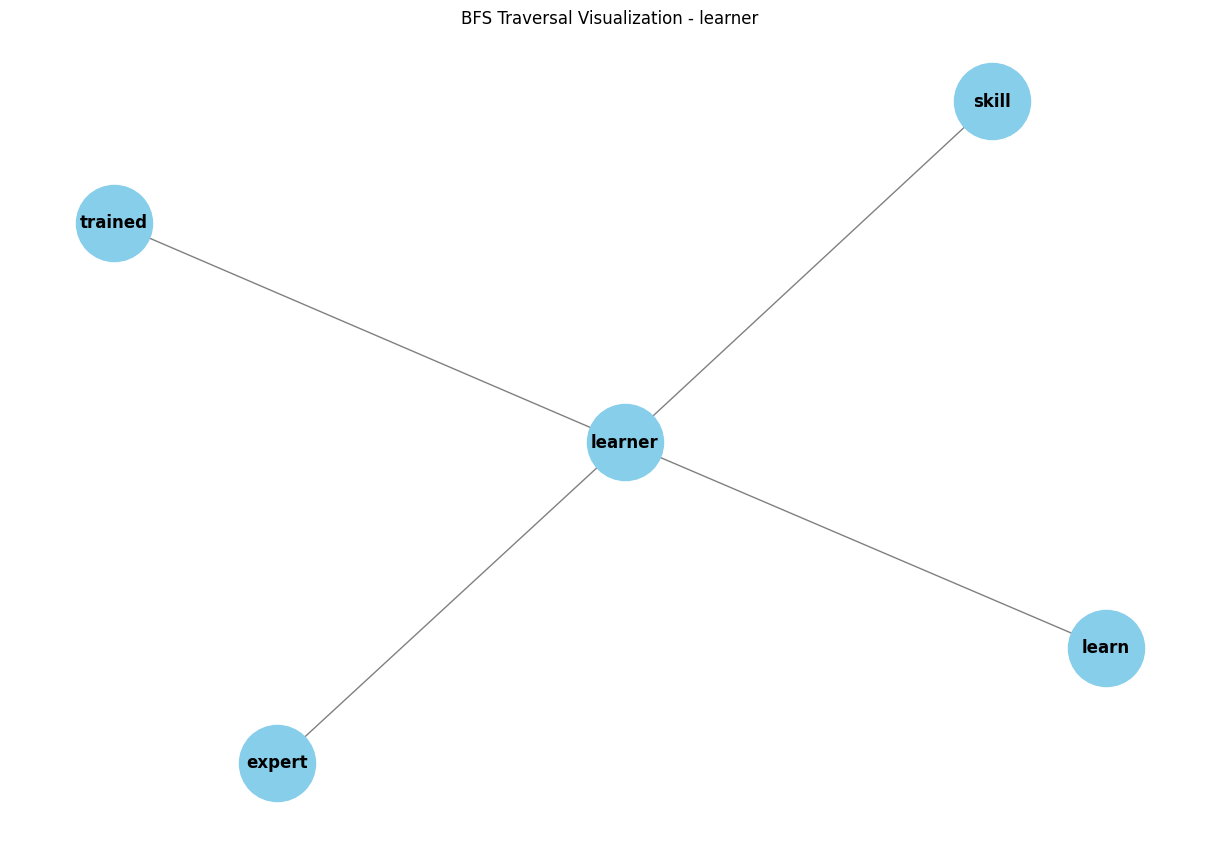

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

class GraphTraversal:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
    
    def get_most_connected_node(self, bucket):
        session = self.driver.session()
        try:
            query = f"""
            MATCH (k:Keyword)-[:RELATED]->(related:Keyword)
            WHERE k.bucket = '{bucket}'
            RETURN k.name AS keyword, COUNT(related) AS connections
            ORDER BY connections DESC
            LIMIT 1
            """
            result = session.run(query)
            most_connected_node = result.single()
            if most_connected_node:
                return most_connected_node["keyword"]
            else:
                return None

        finally:
            session.close()

    def bfs_traversal(self, start_keyword, bucket, depth=3):
        session = self.driver.session()
        try:
            visited = set([start_keyword])
            queue = [start_keyword]
            related_keywords = []
            graph = nx.Graph()  # Create an empty graph for visualization

            graph.add_node(start_keyword)  # Add the starting keyword as a node in the graph

            while queue:
                current_node = queue.pop(0)
                query = f"""
                MATCH (start:Keyword {{name: '{current_node}', bucket: '{bucket}'}})-[r:RELATED]->(related:Keyword)
                RETURN related, r.weight AS weight
                ORDER BY weight DESC
                """
                result = session.run(query)

                for record in result:
                    related_keyword = record["related"]["name"]
                    weight = record["weight"]
                    if related_keyword not in visited:
                        visited.add(related_keyword)
                        queue.append(related_keyword)  # Add the related keyword to the queue based on the highest weight
                        related_keywords.append(related_keyword)
                        graph.add_node(related_keyword)  # Add the related keyword as a node
                        graph.add_edge(current_node, related_keyword, weight=weight)  # Add an edge with the weight between current and related nodes

            # Visualize the graph
            pos = nx.spring_layout(graph, seed=42)  # Positioning nodes using spring layout
            plt.figure(figsize=(12, 8))
            nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
            plt.title(f"BFS Traversal Visualization - {start_keyword}")
            plt.show()

            return related_keywords

        finally:
            session.close()

# Initialize the GraphTraversal instance
graph_traversal = GraphTraversal(uri="bolt://localhost:7687", username="neo4j", password="akashbhumi")

# Define the bucket to work with (bucket1, bucket2, or bucket3)
bucket = 'bucket1'

# Get the most connected node in the specified bucket
start_keyword = graph_traversal.get_most_connected_node(bucket)

if start_keyword:
    print(f"Starting BFS traversal from keyword: {start_keyword}")
    bucket1_traversal_keywords = graph_traversal.bfs_traversal(start_keyword, bucket, depth=3)
  
else:
    print(f"No connected nodes found in {bucket}.")


Starting BFS traversal from keyword: learner


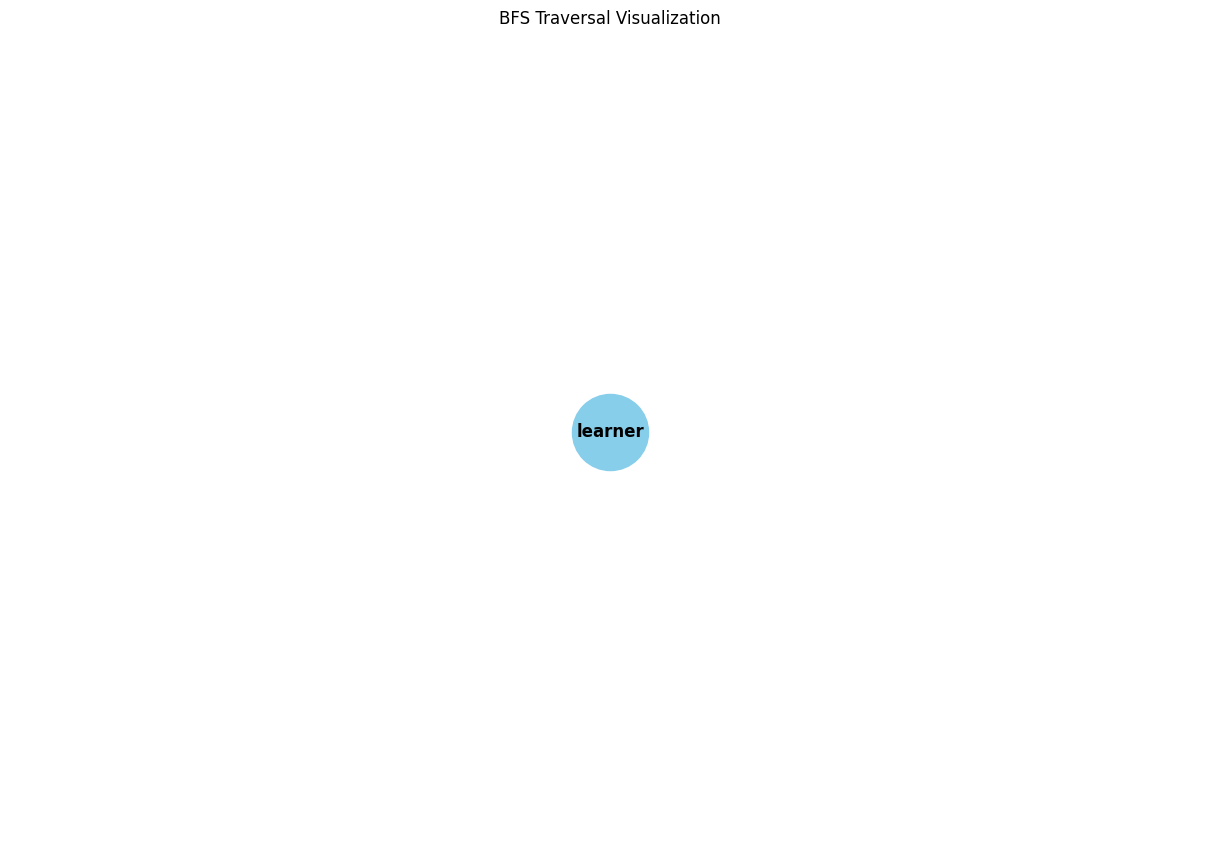

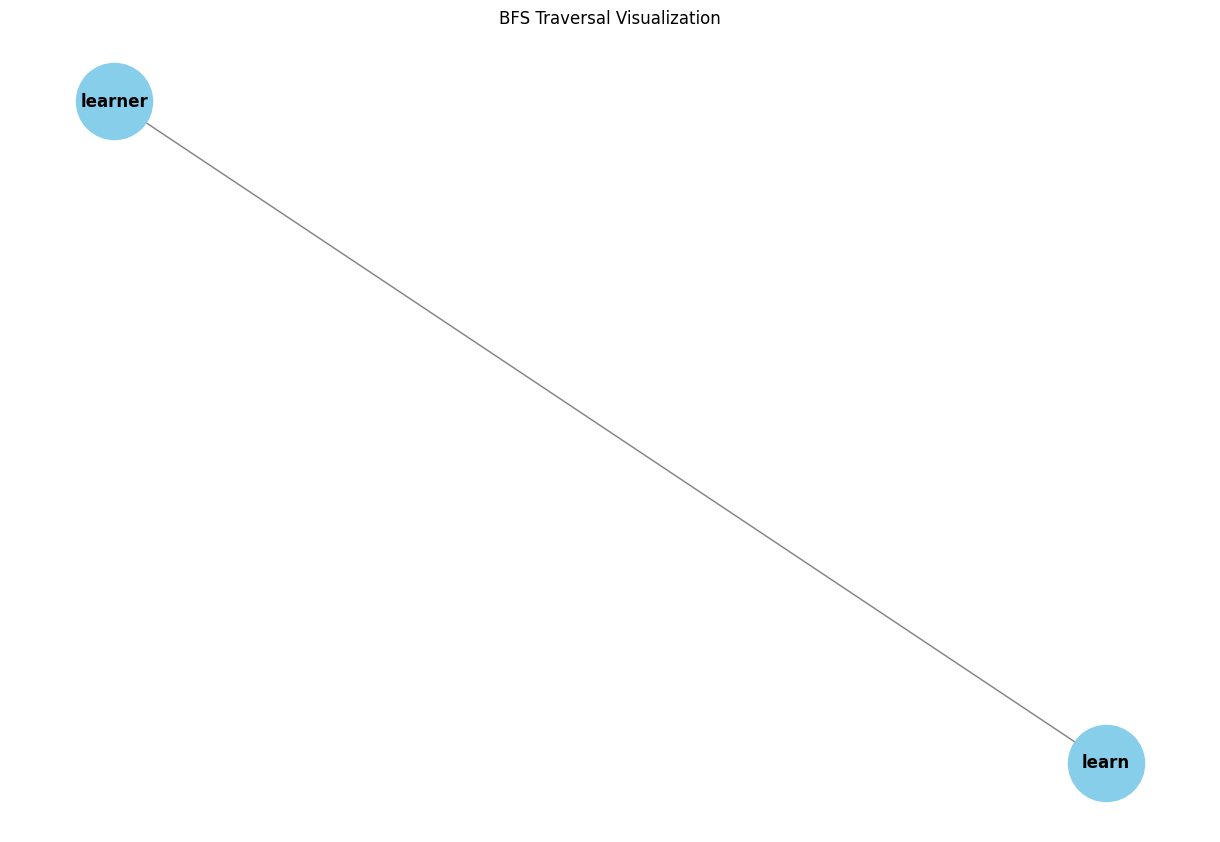

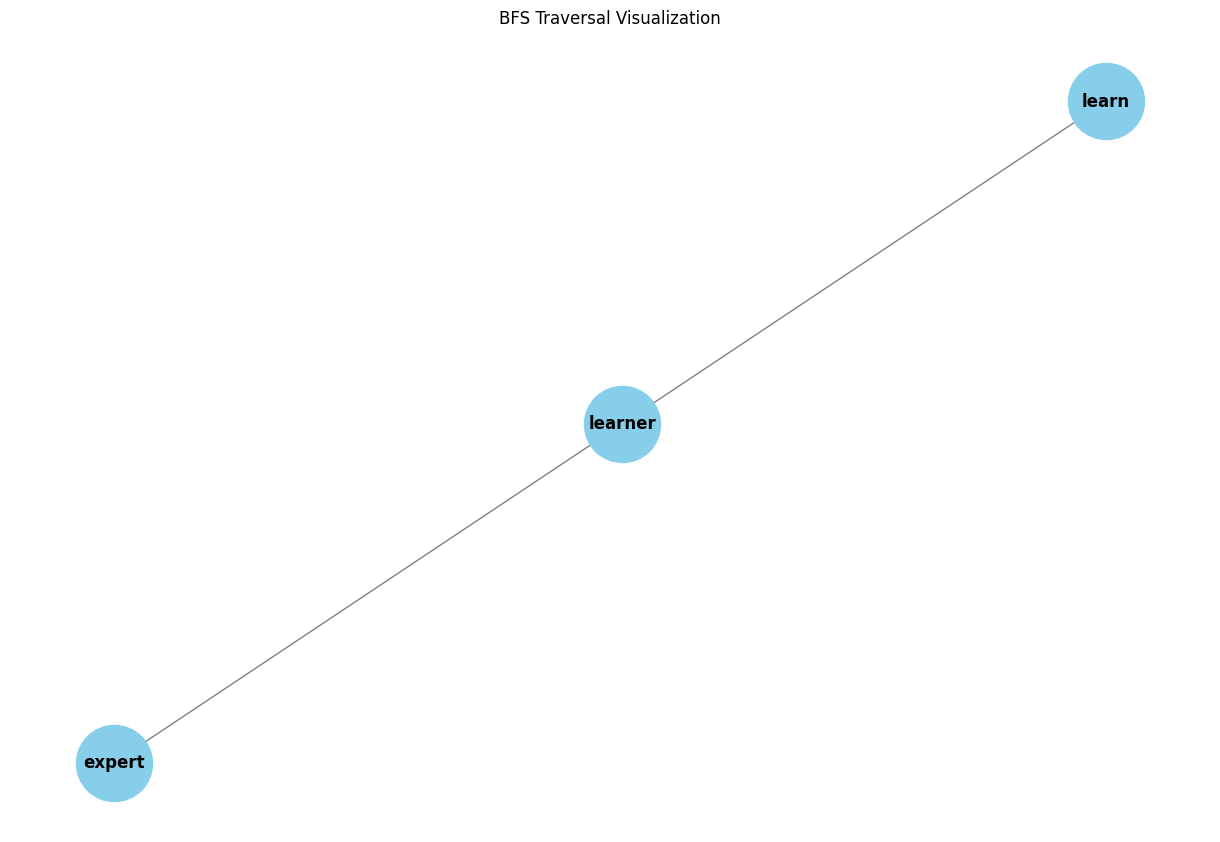

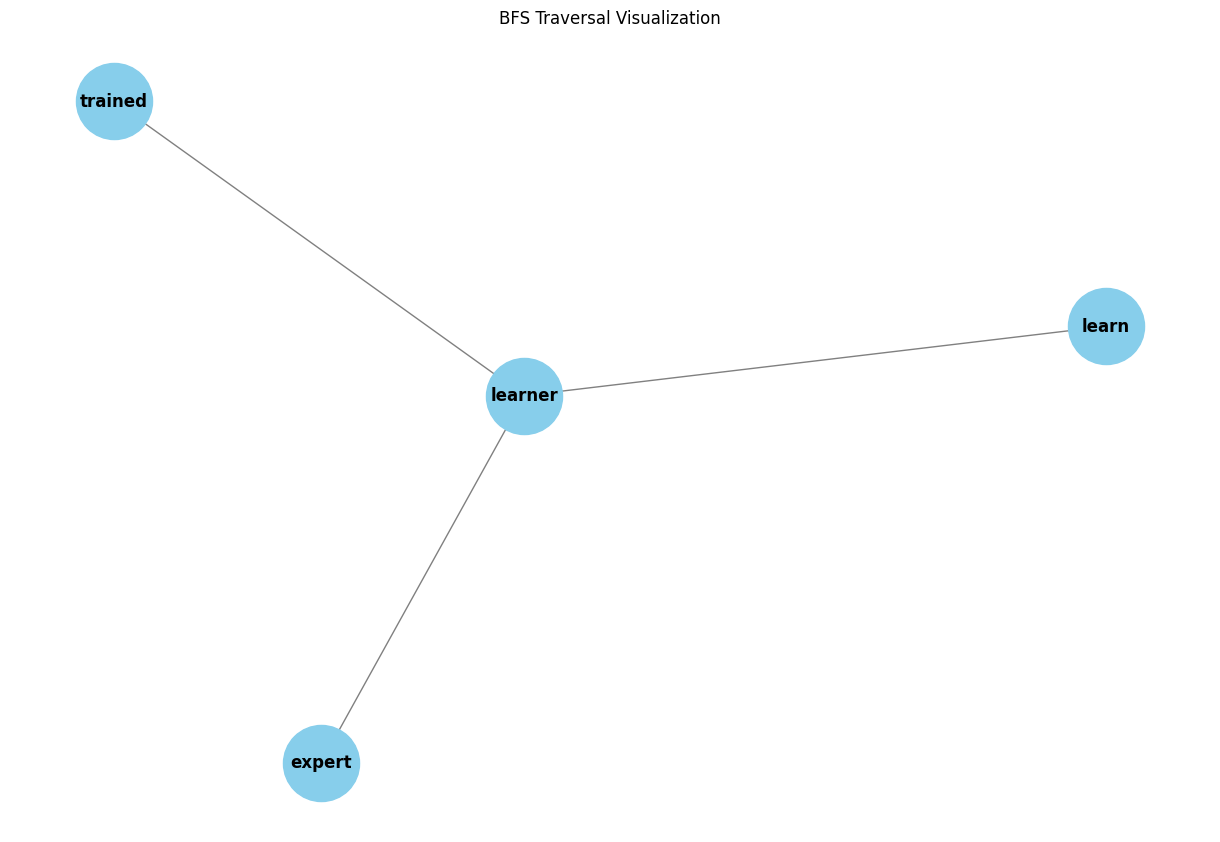

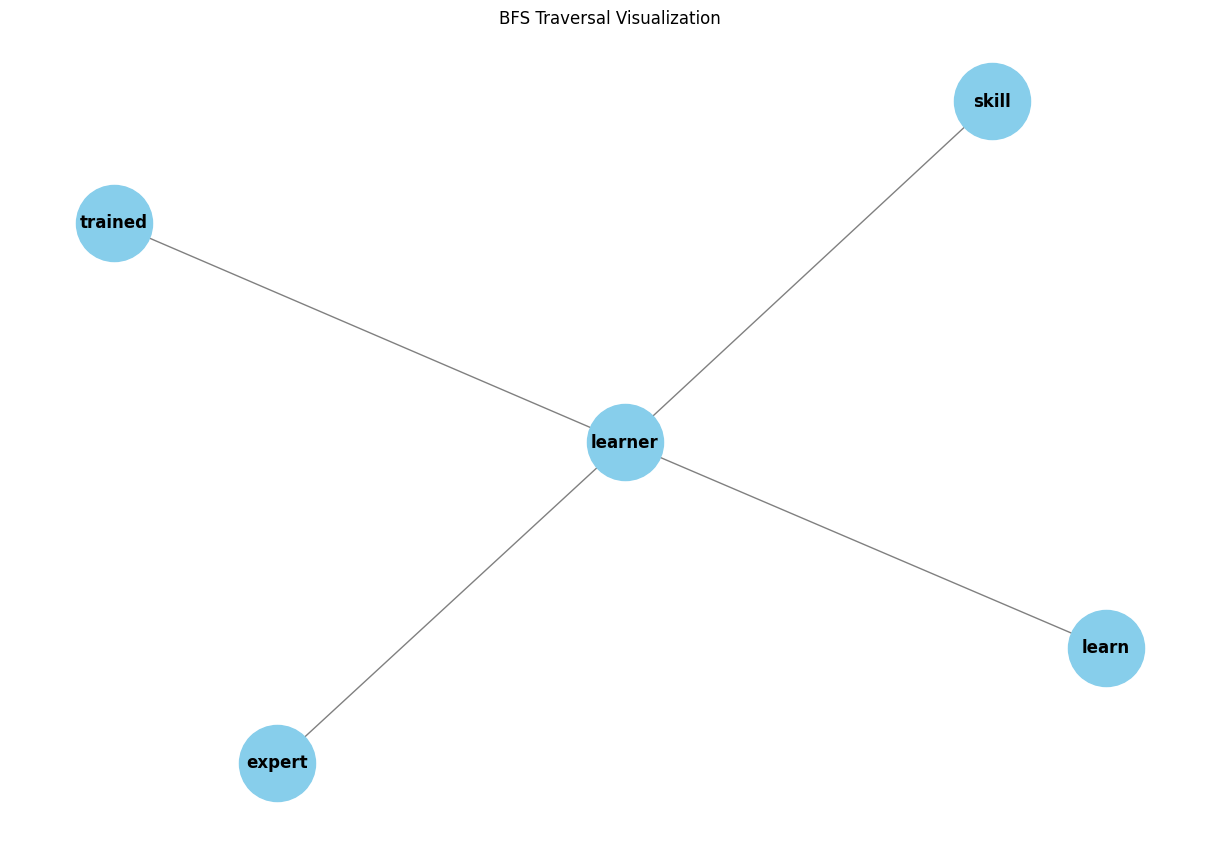

Related Keywords: ['learner', 'learn', 'expert', 'trained', 'skill']


In [67]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import time  # To add a delay between each node visualization

class GraphTraversal:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
    
    def get_most_connected_node(self, bucket):
        session = self.driver.session()
        try:
            query = f"""
            MATCH (k:Keyword)-[:RELATED]->(related:Keyword)
            WHERE k.bucket = '{bucket}'
            RETURN k.name AS keyword, COUNT(related) AS connections
            ORDER BY connections DESC
            LIMIT 1
            """
            result = session.run(query)
            most_connected_node = result.single()
            if most_connected_node:
                return most_connected_node["keyword"]
            else:
                return None
        finally:
            session.close()

    def bfs_traversal(self, start_keyword, bucket, depth=3):
        session = self.driver.session()
        try:
            visited = set([start_keyword])
            queue = [start_keyword]
            related_keywords = []
            graph = nx.Graph()  # Create an empty graph for visualization

            graph.add_node(start_keyword)  # Add the starting keyword as a node in the graph

            # Visualize initial state
            self.visualize_graph(graph)

            while queue:
                current_node = queue.pop(0)
                query = f"""
                MATCH (start:Keyword {{name: '{current_node}', bucket: '{bucket}'}})-[r:RELATED]->(related:Keyword)
                RETURN related, r.weight AS weight
                ORDER BY weight DESC
                """
                result = session.run(query)

                # Create a list of neighbors sorted by weight in descending order
                sorted_neighbors = []
                for record in result:
                    related_keyword = record["related"]["name"]
                    weight = record["weight"]
                    sorted_neighbors.append((related_keyword, weight))
                
                # Add neighbors to the queue based on sorted weight order
                for related_keyword, weight in sorted_neighbors:
                    if related_keyword not in visited:
                        visited.add(related_keyword)
                        queue.append(related_keyword)
                        related_keywords.append(related_keyword)
                        graph.add_node(related_keyword)  # Add the related keyword as a node
                        graph.add_edge(current_node, related_keyword, weight=weight)  # Add an edge with the weight between nodes

                        # Visualize graph after adding a new node
                        self.visualize_graph(graph)

            return related_keywords

        finally:
            session.close()

    def visualize_graph(self, graph):
        """Visualize the graph after each node is added."""
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(graph, seed=42)  # Positioning nodes using spring layout
        nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
        plt.title(f"BFS Traversal Visualization")
        plt.show()
        time.sleep(1)  # Pause for 1 second to make the visualization step-by-step

# Initialize the GraphTraversal instance
graph_traversal = GraphTraversal(uri="bolt://localhost:7687", username="neo4j", password="akashbhumi")

# Define the bucket to work with (bucket1, bucket2, or bucket3)
bucket = 'bucket1'

# Get the most connected node in the specified bucket
start_keyword = graph_traversal.get_most_connected_node(bucket)

if start_keyword:
    print(f"Starting BFS traversal from keyword: {start_keyword}")
    bucket1_traversal_keywords = [start_keyword] + graph_traversal.bfs_traversal(start_keyword, bucket, depth=3)
    print("Related Keywords:", bucket1_traversal_keywords)
else:
    print(f"No connected nodes found in {bucket}.")


Starting BFS traversal from keyword: learning


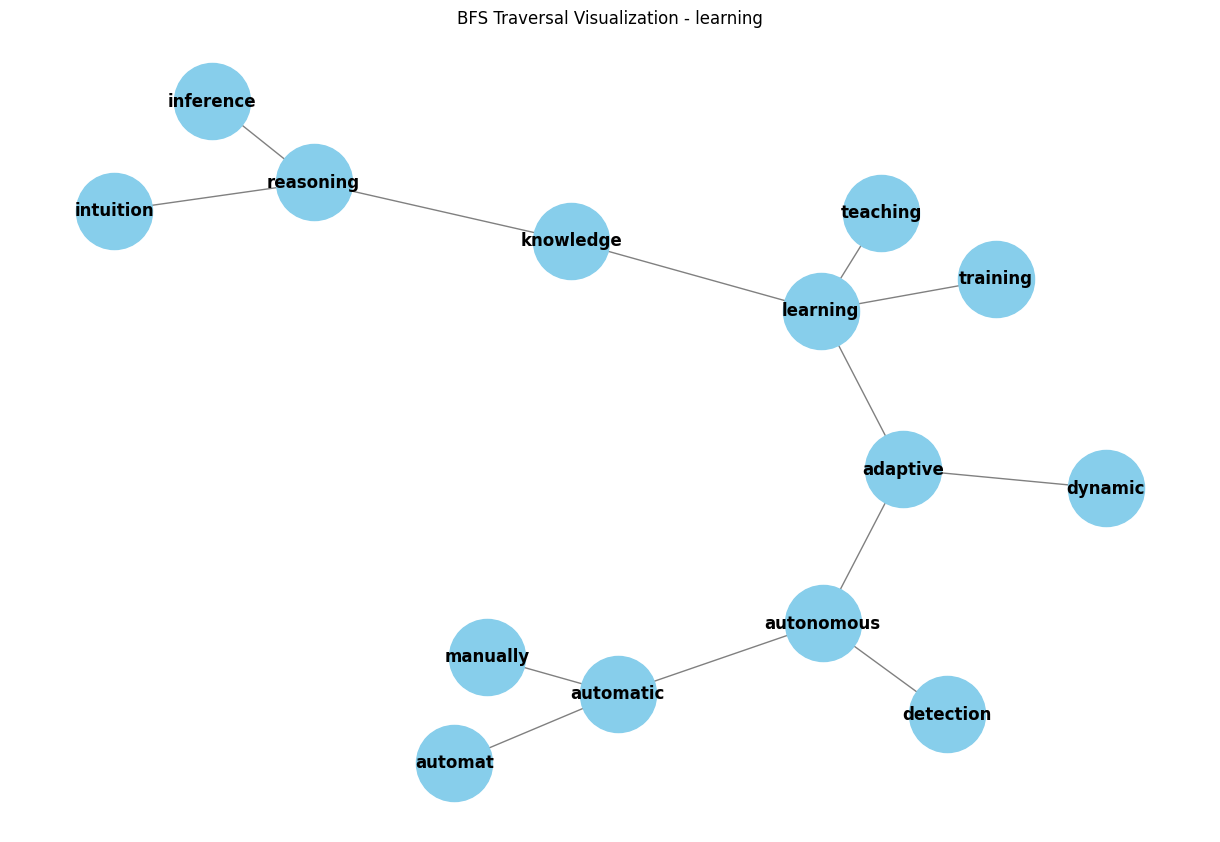

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

class GraphTraversal:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
    
    def get_most_connected_node(self, bucket):
        session = self.driver.session()
        try:
            query = f"""
            MATCH (k:Keyword)-[:RELATED]->(related:Keyword)
            WHERE k.bucket = '{bucket}'
            RETURN k.name AS keyword, COUNT(related) AS connections
            ORDER BY connections DESC
            LIMIT 1
            """
            result = session.run(query)
            most_connected_node = result.single()
            if most_connected_node:
                return most_connected_node["keyword"]
            else:
                return None

        finally:
            session.close()

    def bfs_traversal(self, start_keyword, bucket, depth=3):
        session = self.driver.session()
        try:
            visited = set([start_keyword])
            queue = [start_keyword]
            related_keywords = []
            graph = nx.Graph()  # Create an empty graph for visualization

            graph.add_node(start_keyword)  # Add the starting keyword as a node in the graph

            while queue:
                current_node = queue.pop(0)
                query = f"""
                MATCH (start:Keyword {{name: '{current_node}', bucket: '{bucket}'}})-[r:RELATED]->(related:Keyword)
                RETURN related, r.weight AS weight
                ORDER BY weight DESC
                """
                result = session.run(query)

                for record in result:
                    related_keyword = record["related"]["name"]
                    weight = record["weight"]
                    if related_keyword not in visited:
                        visited.add(related_keyword)
                        queue.append(related_keyword)  # Add the related keyword to the queue based on the highest weight
                        related_keywords.append(related_keyword)
                        graph.add_node(related_keyword)  # Add the related keyword as a node
                        graph.add_edge(current_node, related_keyword, weight=weight)  # Add an edge with the weight between current and related nodes

            # Visualize the graph
            pos = nx.spring_layout(graph, seed=42)  # Positioning nodes using spring layout
            plt.figure(figsize=(12, 8))
            nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
            plt.title(f"BFS Traversal Visualization - {start_keyword}")
            plt.show()

            return related_keywords

        finally:
            session.close()

# Initialize the GraphTraversal instance
graph_traversal = GraphTraversal(uri="bolt://localhost:7687", username="neo4j", password="akashbhumi")

# Define the bucket to work with (bucket1, bucket2, or bucket3)
bucket = 'bucket2'

# Get the most connected node in the specified bucket
start_keyword = graph_traversal.get_most_connected_node(bucket)

if start_keyword:
    print(f"Starting BFS traversal from keyword: {start_keyword}")
    bucket2_traversal_keywords = graph_traversal.bfs_traversal(start_keyword, bucket, depth=3)
else:
    print(f"No connected nodes found in {bucket}.")


Starting BFS traversal from keyword: learning


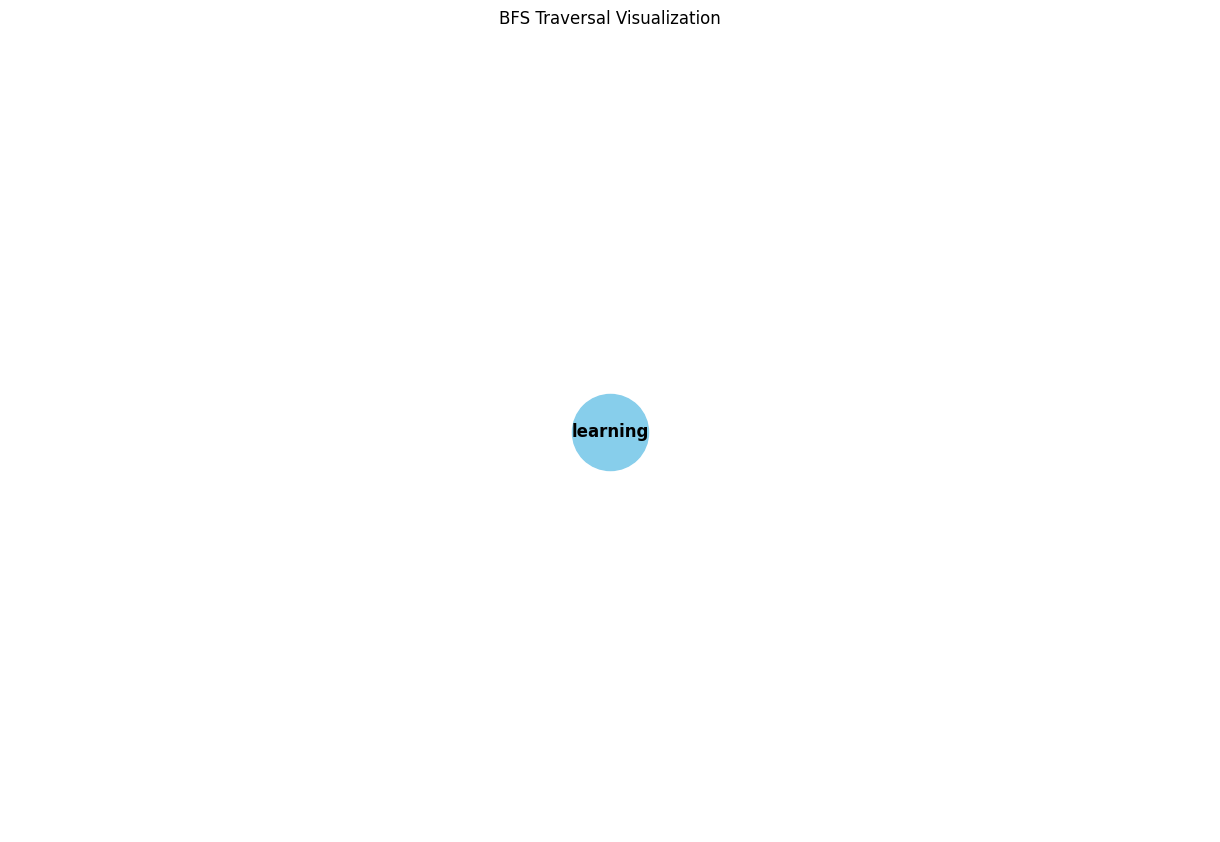

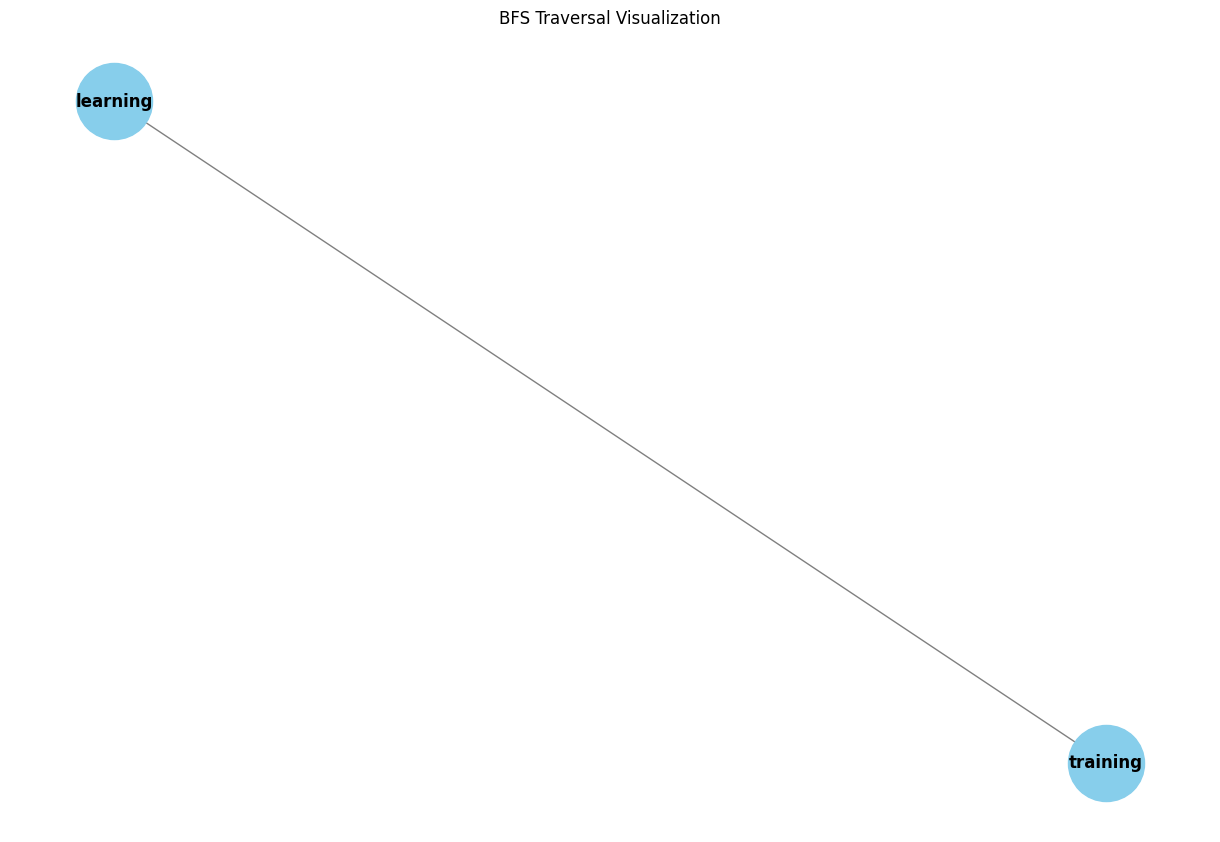

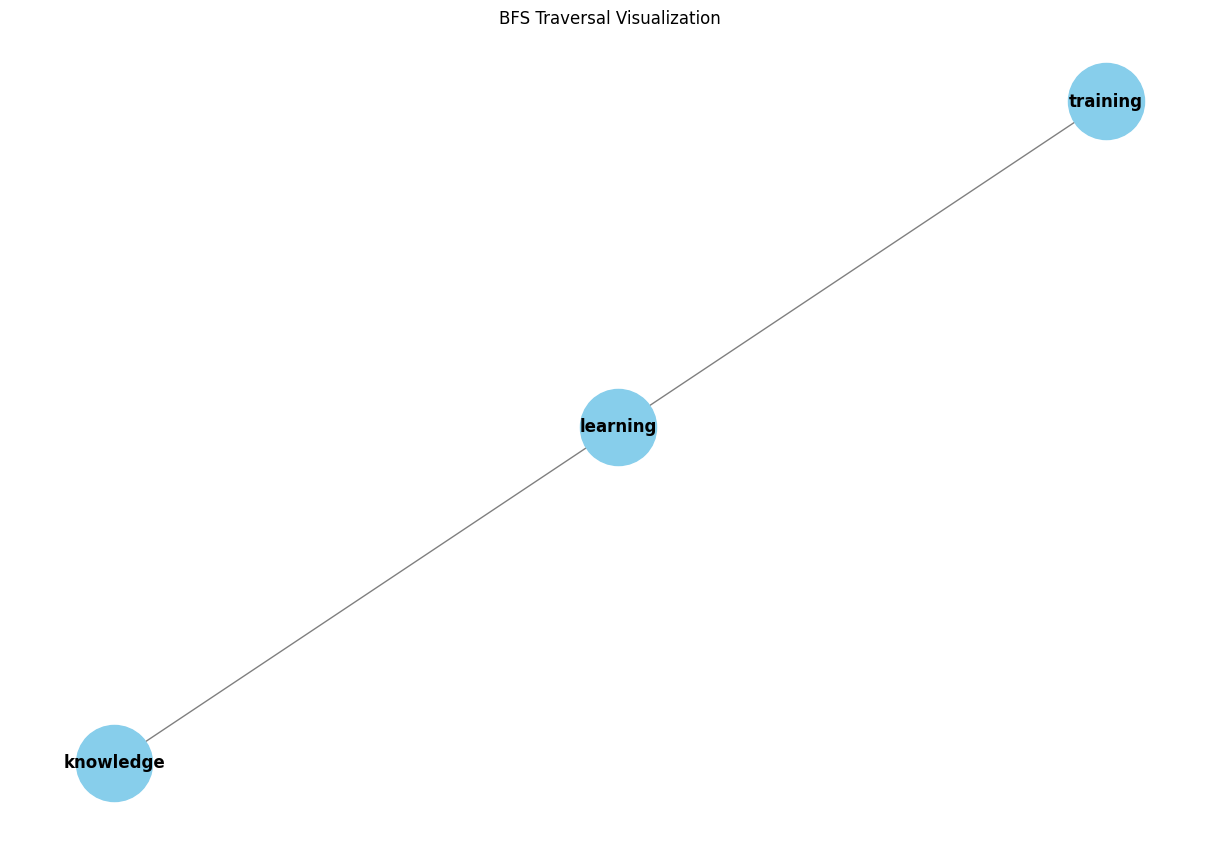

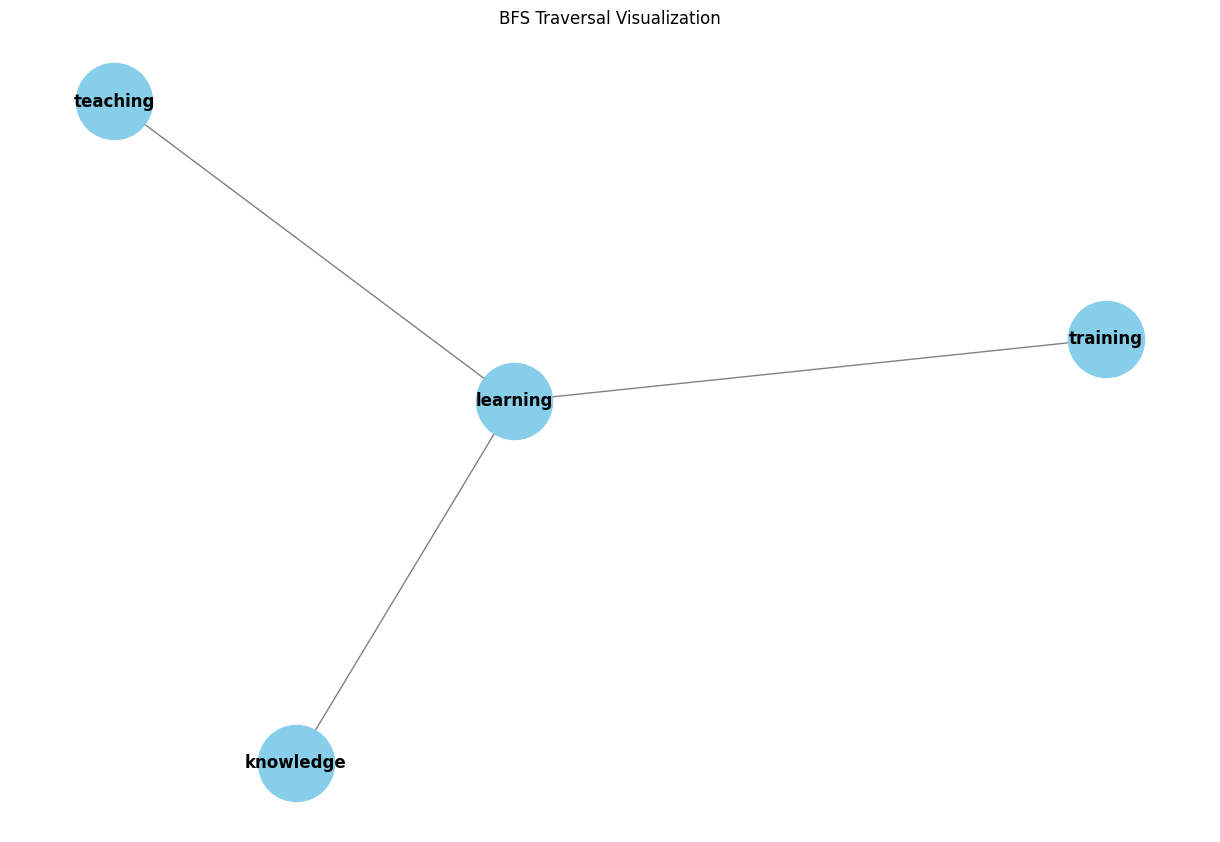

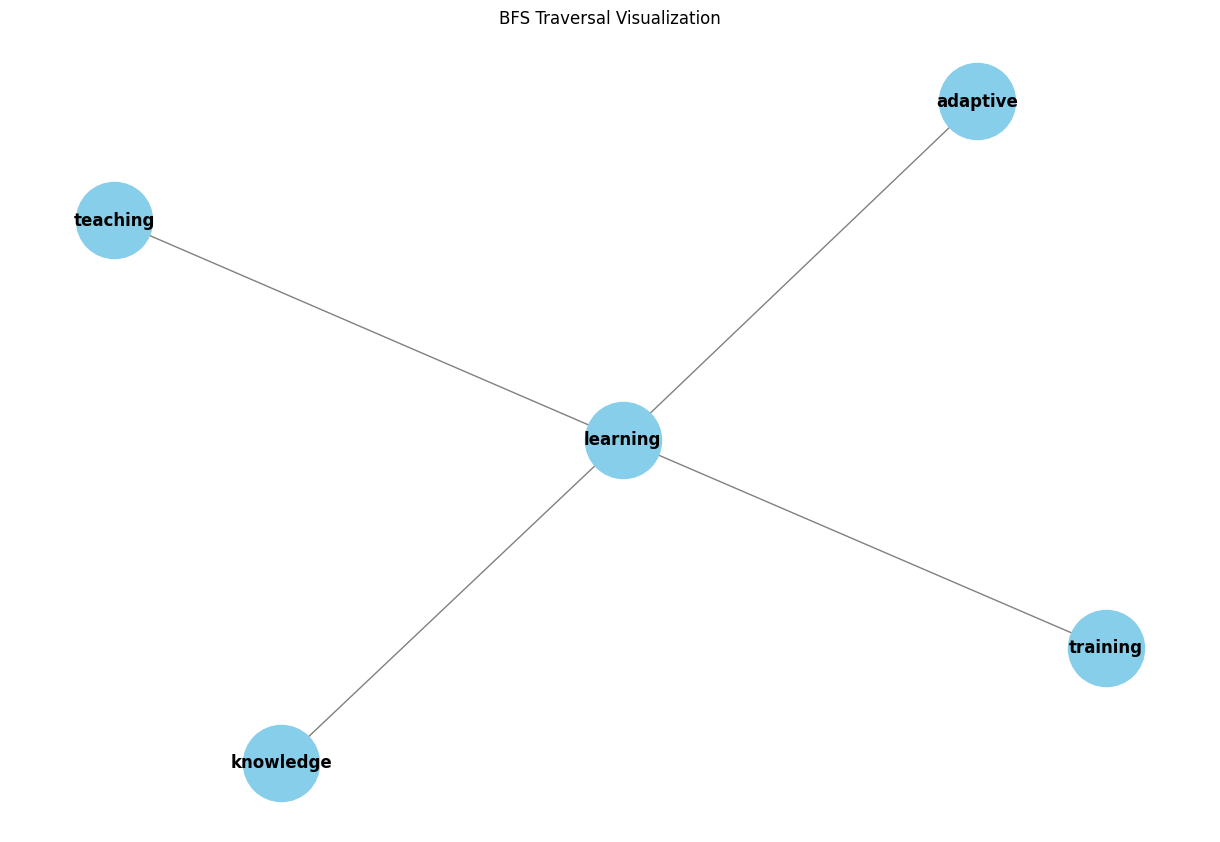

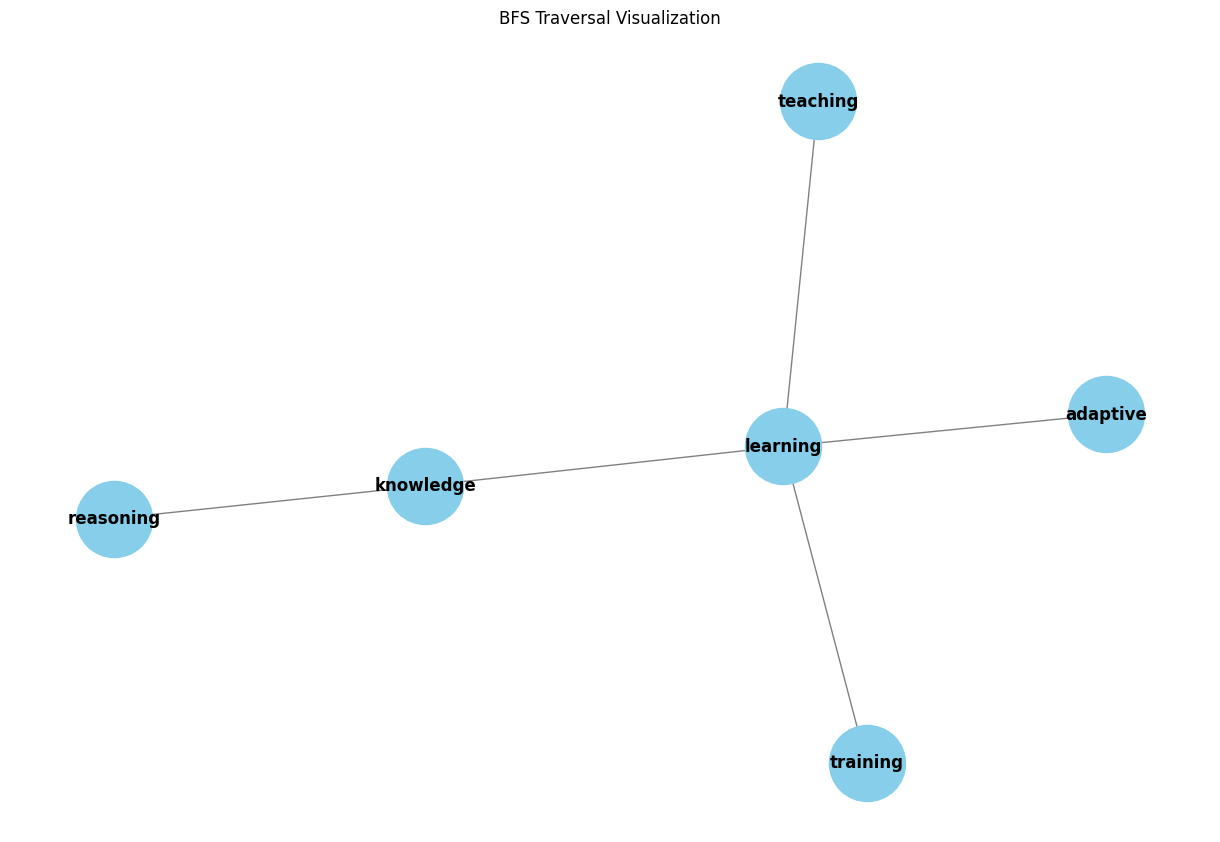

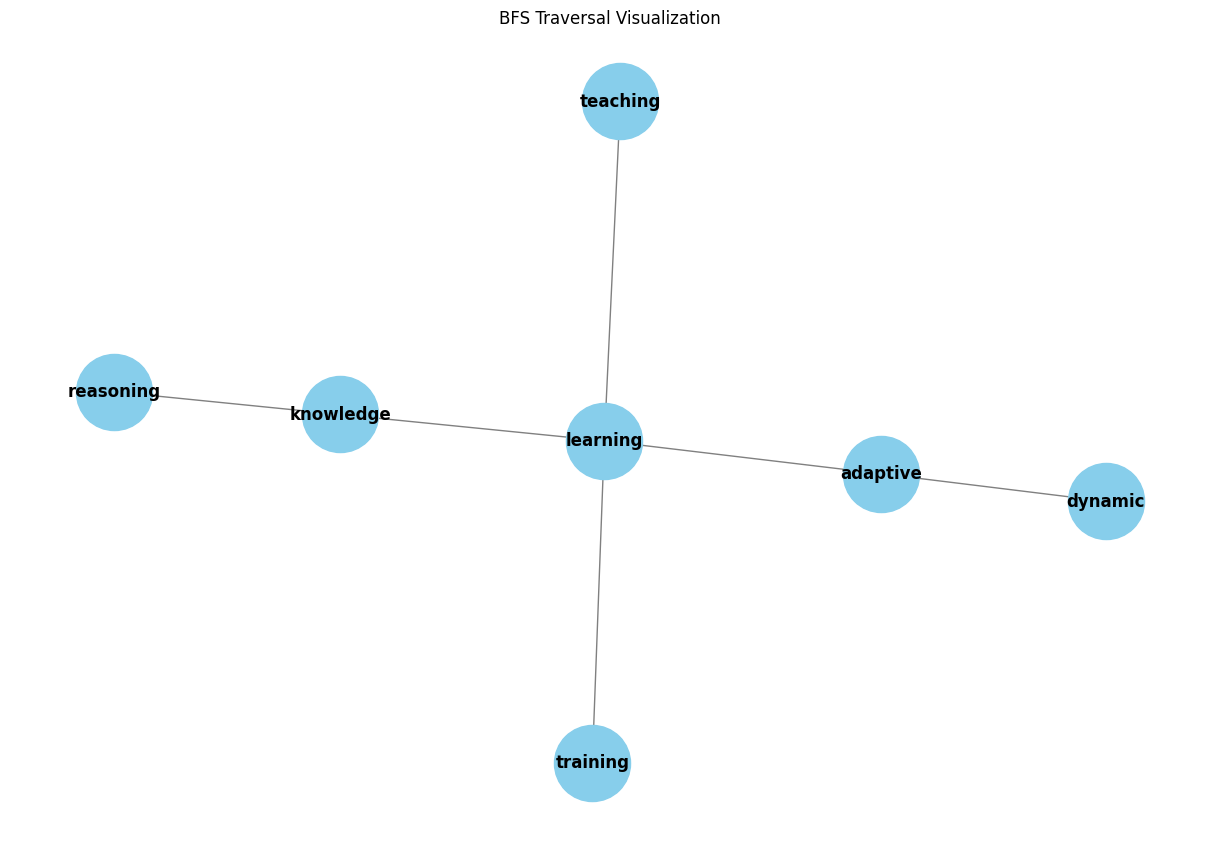

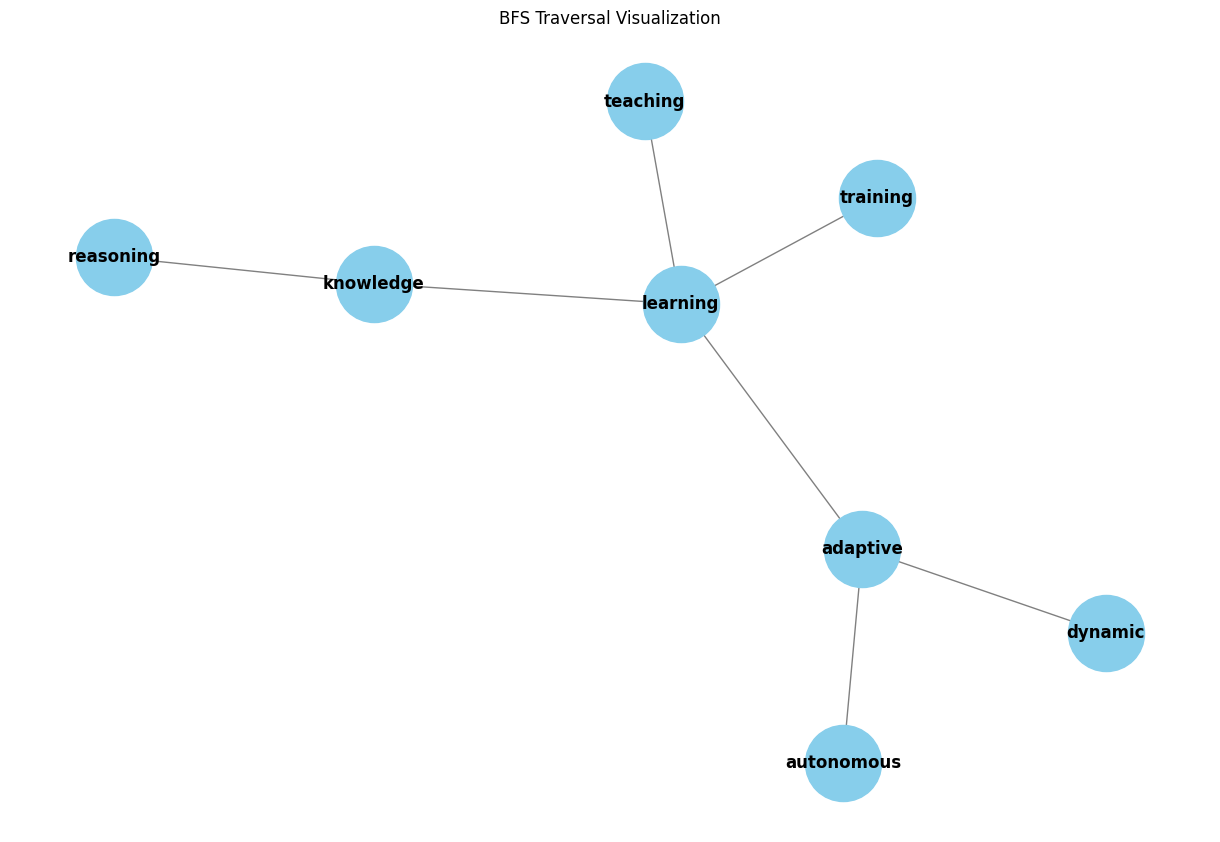

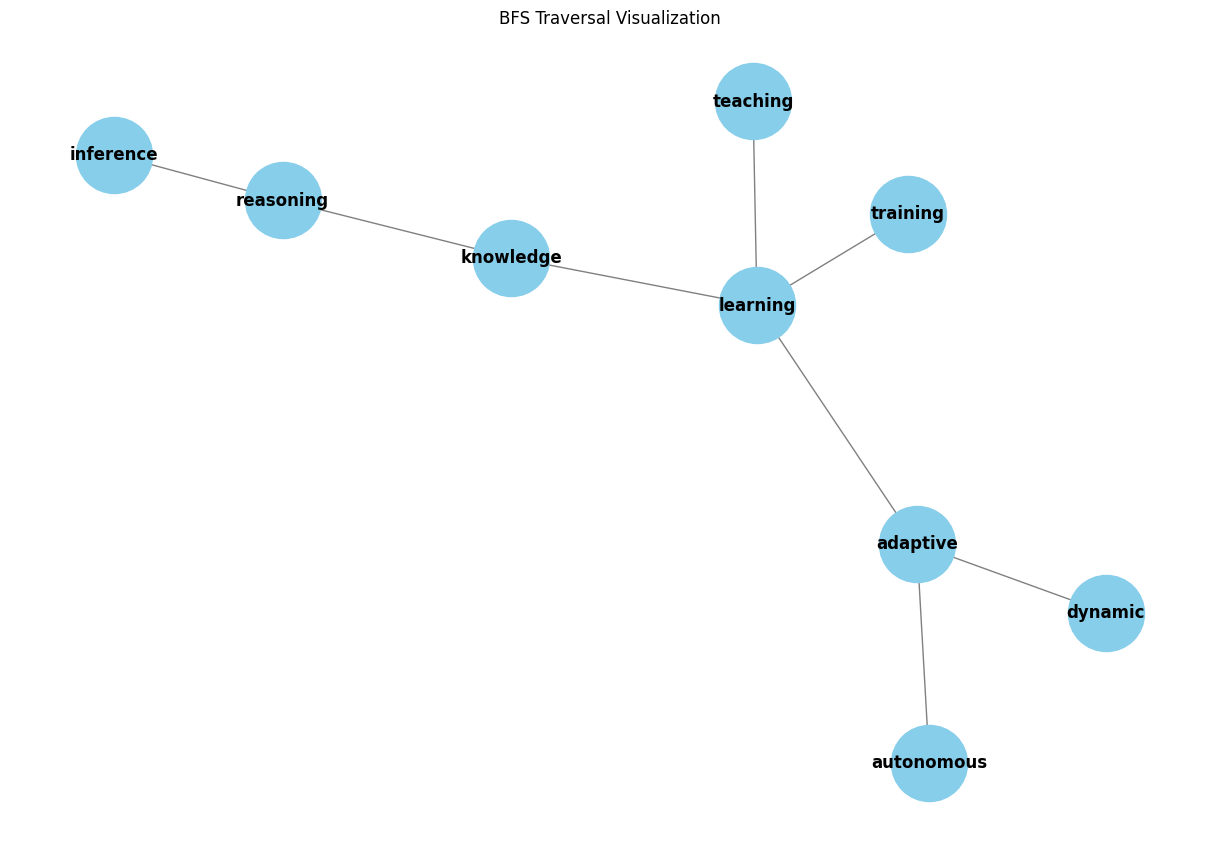

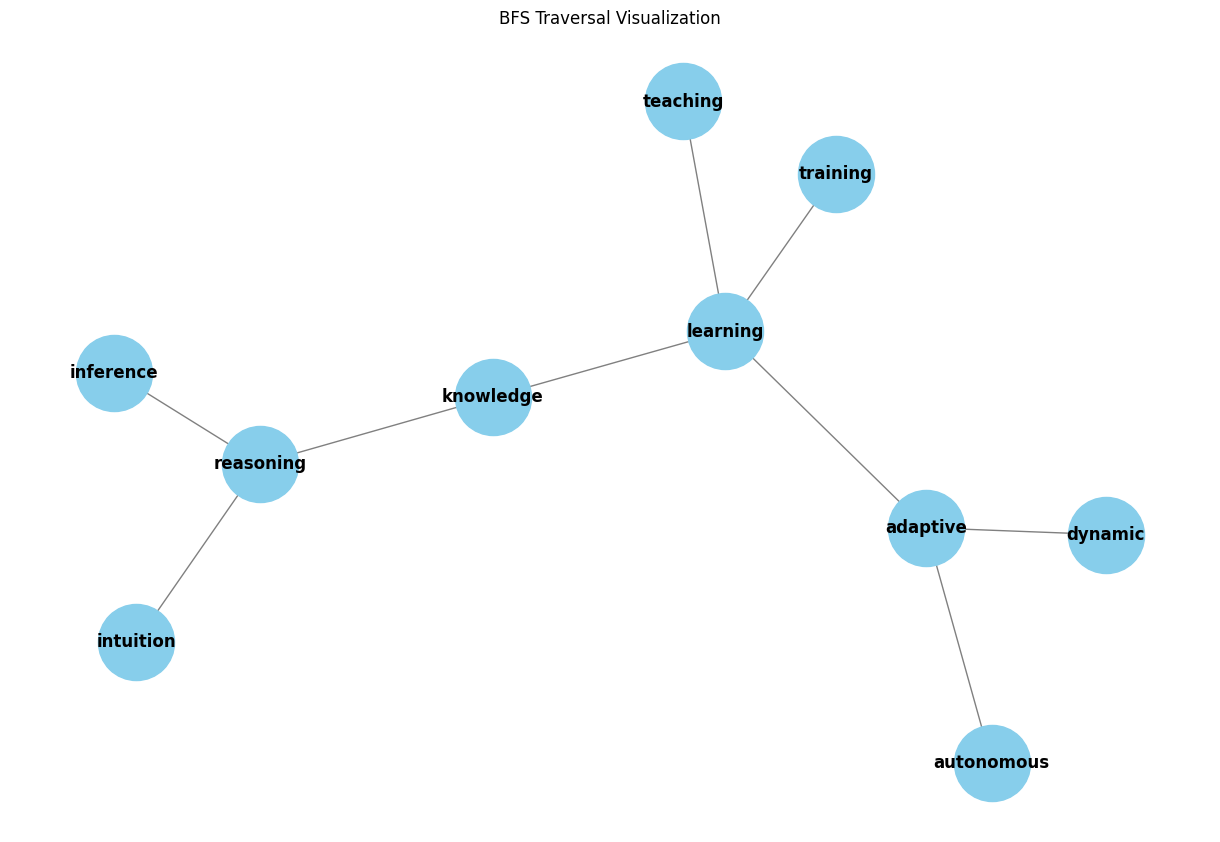

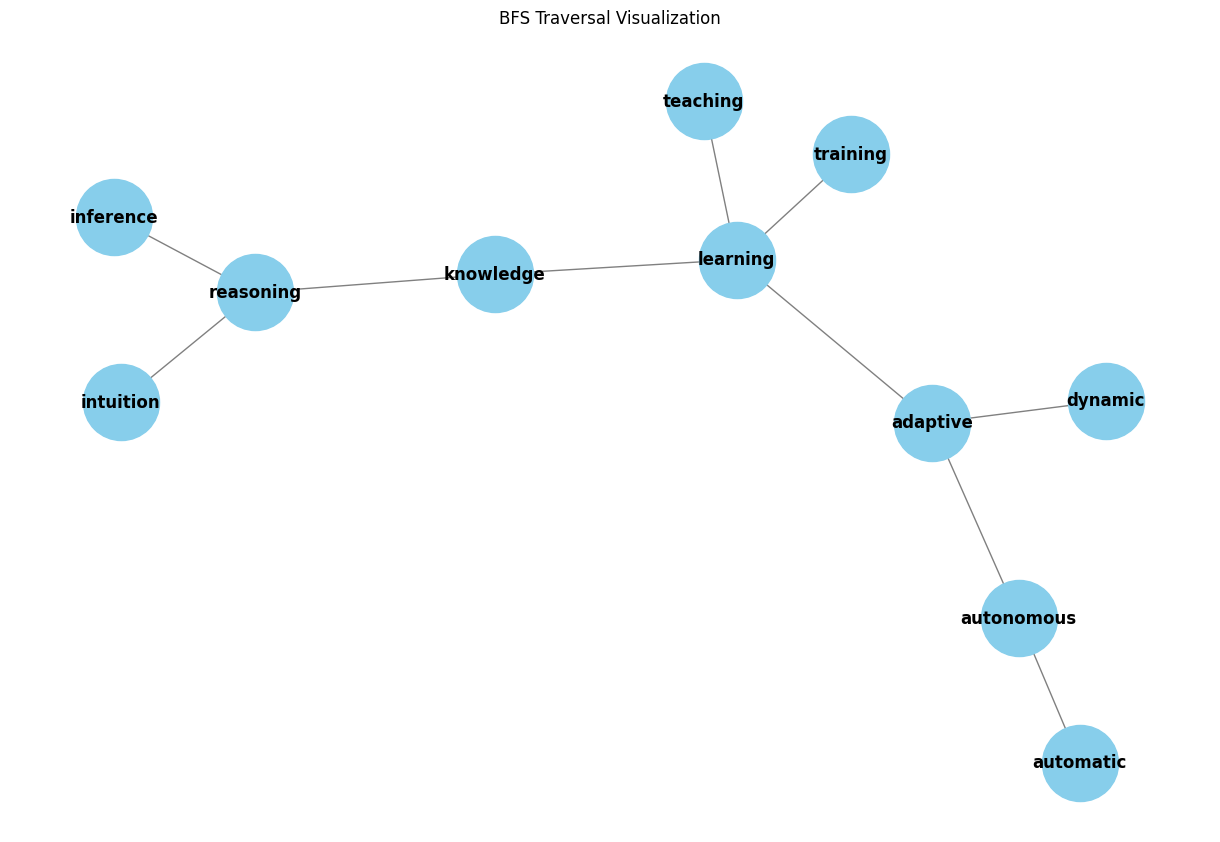

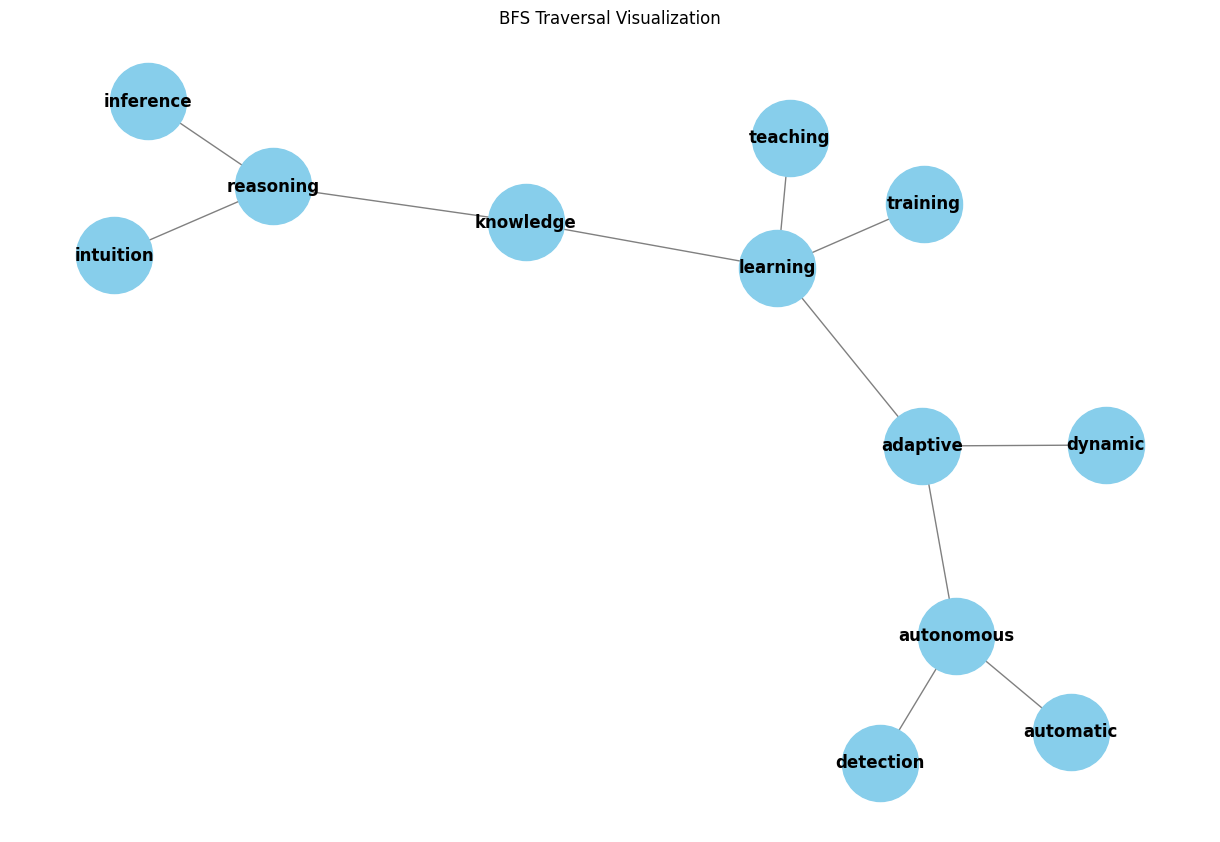

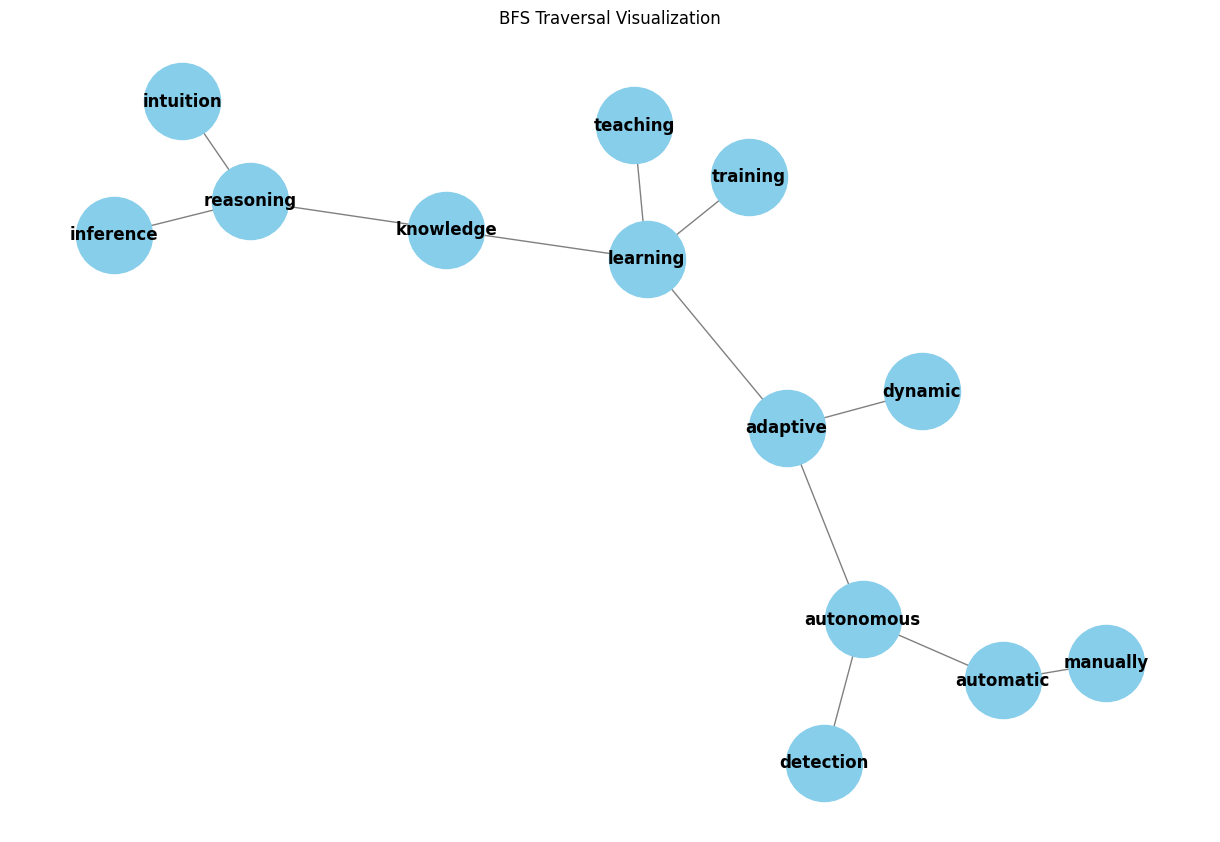

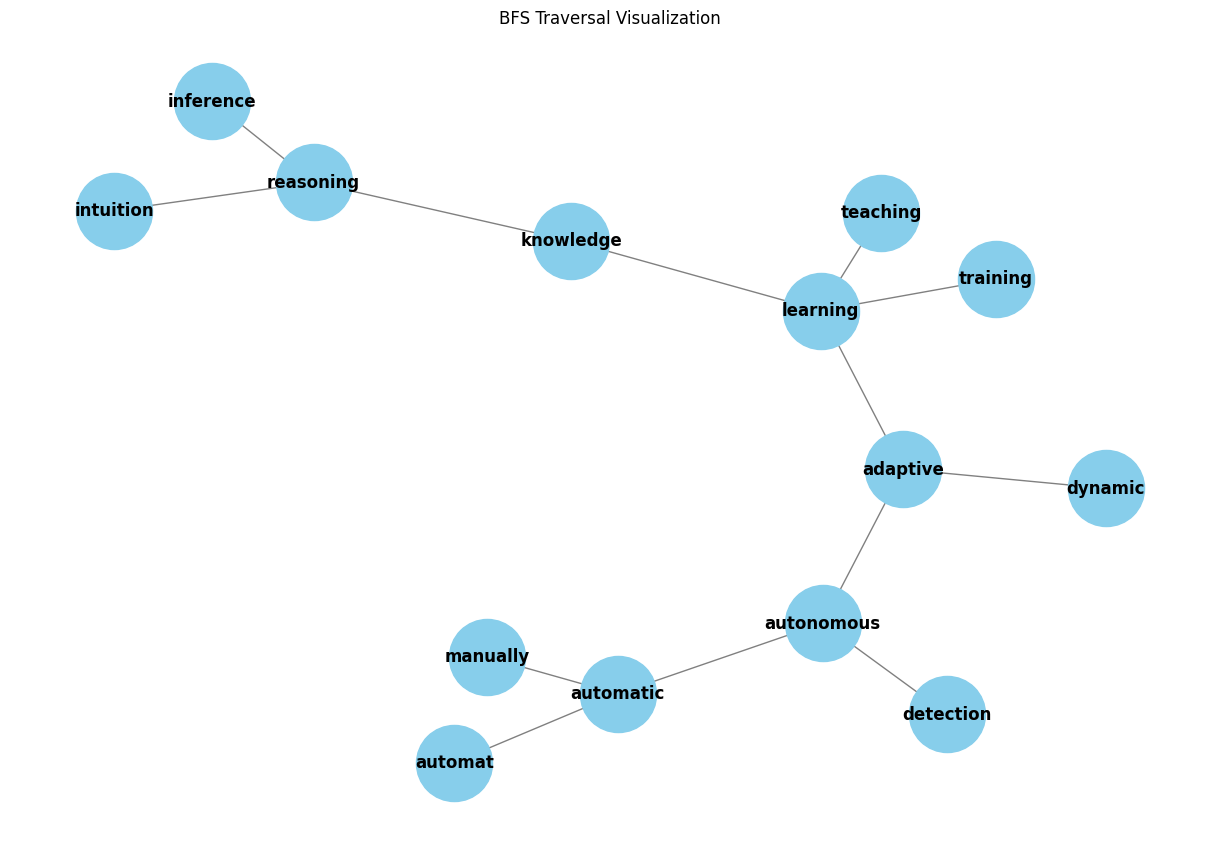

Related Keywords: ['learning', 'training', 'knowledge', 'teaching', 'adaptive', 'reasoning', 'dynamic', 'autonomous', 'inference', 'intuition', 'automatic', 'detection', 'manually', 'automat']


In [69]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import time  # To add a delay between each node visualization

class GraphTraversal:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
    
    def get_most_connected_node(self, bucket):
        session = self.driver.session()
        try:
            query = f"""
            MATCH (k:Keyword)-[:RELATED]->(related:Keyword)
            WHERE k.bucket = '{bucket}'
            RETURN k.name AS keyword, COUNT(related) AS connections
            ORDER BY connections DESC
            LIMIT 1
            """
            result = session.run(query)
            most_connected_node = result.single()
            if most_connected_node:
                return most_connected_node["keyword"]
            else:
                return None
        finally:
            session.close()

    def bfs_traversal(self, start_keyword, bucket, depth=3):
        session = self.driver.session()
        try:
            visited = set([start_keyword])
            queue = [start_keyword]
            related_keywords = []
            graph = nx.Graph()  # Create an empty graph for visualization

            graph.add_node(start_keyword)  # Add the starting keyword as a node in the graph

            # Visualize initial state
            self.visualize_graph(graph)

            while queue:
                current_node = queue.pop(0)
                query = f"""
                MATCH (start:Keyword {{name: '{current_node}', bucket: '{bucket}'}})-[r:RELATED]->(related:Keyword)
                RETURN related, r.weight AS weight
                ORDER BY weight DESC
                """
                result = session.run(query)

                # Create a list of neighbors sorted by weight in descending order
                sorted_neighbors = []
                for record in result:
                    related_keyword = record["related"]["name"]
                    weight = record["weight"]
                    sorted_neighbors.append((related_keyword, weight))
                
                # Add neighbors to the queue based on sorted weight order
                for related_keyword, weight in sorted_neighbors:
                    if related_keyword not in visited:
                        visited.add(related_keyword)
                        queue.append(related_keyword)
                        related_keywords.append(related_keyword)
                        graph.add_node(related_keyword)  # Add the related keyword as a node
                        graph.add_edge(current_node, related_keyword, weight=weight)  # Add an edge with the weight between nodes

                        # Visualize graph after adding a new node
                        self.visualize_graph(graph)

            return related_keywords

        finally:
            session.close()

    def visualize_graph(self, graph):
        """Visualize the graph after each node is added."""
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(graph, seed=42)  # Positioning nodes using spring layout
        nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
        plt.title(f"BFS Traversal Visualization")
        plt.show()
        time.sleep(1)  # Pause for 1 second to make the visualization step-by-step

# Initialize the GraphTraversal instance
graph_traversal = GraphTraversal(uri="bolt://localhost:7687", username="neo4j", password="akashbhumi")

# Define the bucket to work with (bucket1, bucket2, or bucket3)
bucket = 'bucket2'

# Get the most connected node in the specified bucket
start_keyword = graph_traversal.get_most_connected_node(bucket)

if start_keyword:
    print(f"Starting BFS traversal from keyword: {start_keyword}")
    bucket2_traversal_keywords = [start_keyword] + graph_traversal.bfs_traversal(start_keyword, bucket, depth=3)
    print("Related Keywords:", bucket2_traversal_keywords)
else:
    print(f"No connected nodes found in {bucket}.")


Starting BFS traversal from keyword: recognition


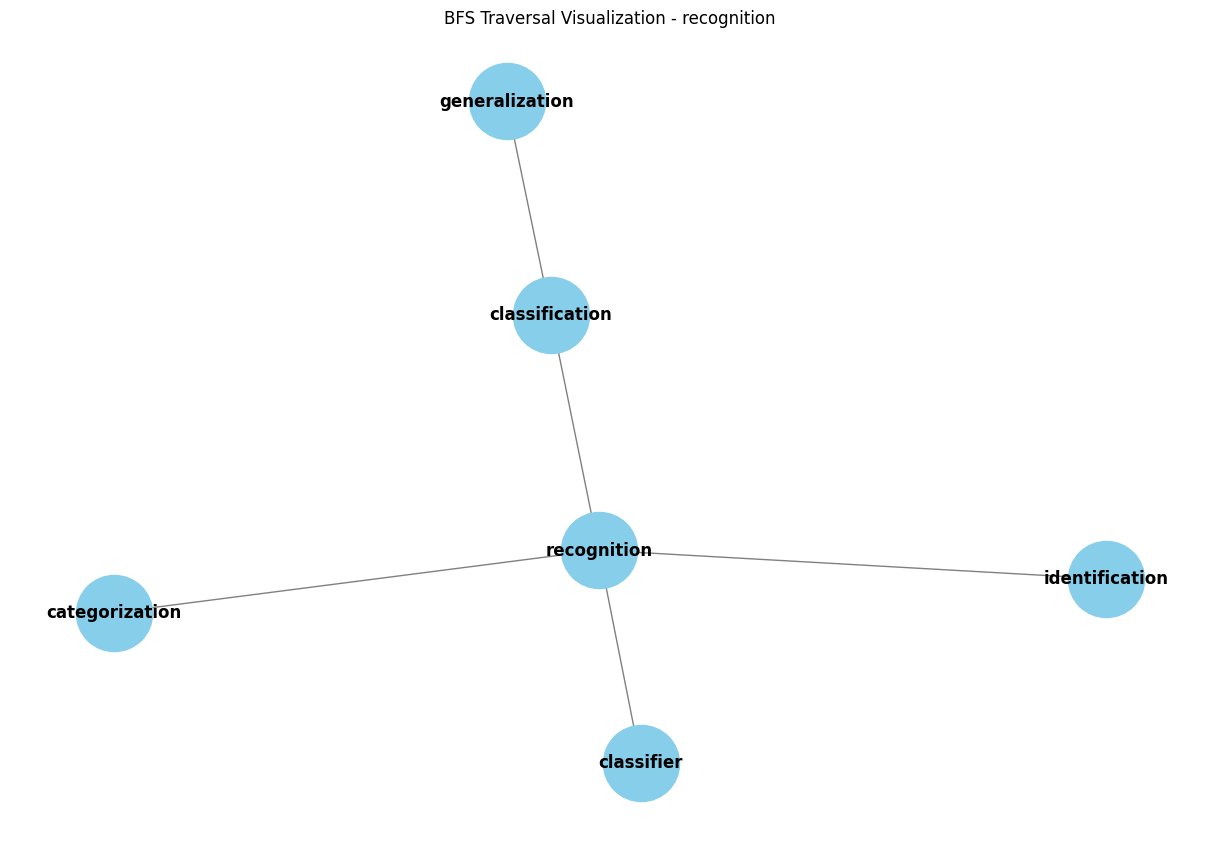

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

class GraphTraversal:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
    
    def get_most_connected_node(self, bucket):
        session = self.driver.session()
        try:
            query = f"""
            MATCH (k:Keyword)-[:RELATED]->(related:Keyword)
            WHERE k.bucket = '{bucket}'
            RETURN k.name AS keyword, COUNT(related) AS connections
            ORDER BY connections DESC
            LIMIT 1
            """
            result = session.run(query)
            most_connected_node = result.single()
            if most_connected_node:
                return most_connected_node["keyword"]
            else:
                return None

        finally:
            session.close()

    def bfs_traversal(self, start_keyword, bucket, depth=3):
        session = self.driver.session()
        try:
            visited = set([start_keyword])
            queue = [start_keyword]
            related_keywords = []
            graph = nx.Graph()  # Create an empty graph for visualization

            graph.add_node(start_keyword)  # Add the starting keyword as a node in the graph

            while queue:
                current_node = queue.pop(0)
                query = f"""
                MATCH (start:Keyword {{name: '{current_node}', bucket: '{bucket}'}})-[r:RELATED]->(related:Keyword)
                RETURN related, r.weight AS weight
                ORDER BY weight DESC
                """
                result = session.run(query)

                for record in result:
                    related_keyword = record["related"]["name"]
                    weight = record["weight"]
                    if related_keyword not in visited:
                        visited.add(related_keyword)
                        queue.append(related_keyword)  # Add the related keyword to the queue based on the highest weight
                        related_keywords.append(related_keyword)
                        graph.add_node(related_keyword)  # Add the related keyword as a node
                        graph.add_edge(current_node, related_keyword, weight=weight)  # Add an edge with the weight between current and related nodes

            # Visualize the graph
            pos = nx.spring_layout(graph, seed=42)  # Positioning nodes using spring layout
            plt.figure(figsize=(12, 8))
            nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
            plt.title(f"BFS Traversal Visualization - {start_keyword}")
            plt.show()

            return related_keywords

        finally:
            session.close()

# Initialize the GraphTraversal instance
graph_traversal = GraphTraversal(uri="bolt://localhost:7687", username="neo4j", password="akashbhumi")

# Define the bucket to work with (bucket1, bucket2, or bucket3)
bucket = 'bucket3'

# Get the most connected node in the specified bucket
start_keyword = graph_traversal.get_most_connected_node(bucket)

if start_keyword:
    print(f"Starting BFS traversal from keyword: {start_keyword}")
    bucket3_traversal_keywords = graph_traversal.bfs_traversal(start_keyword, bucket, depth=3)
else:
    print(f"No connected nodes found in {bucket}.")


Starting BFS traversal from keyword: recognition


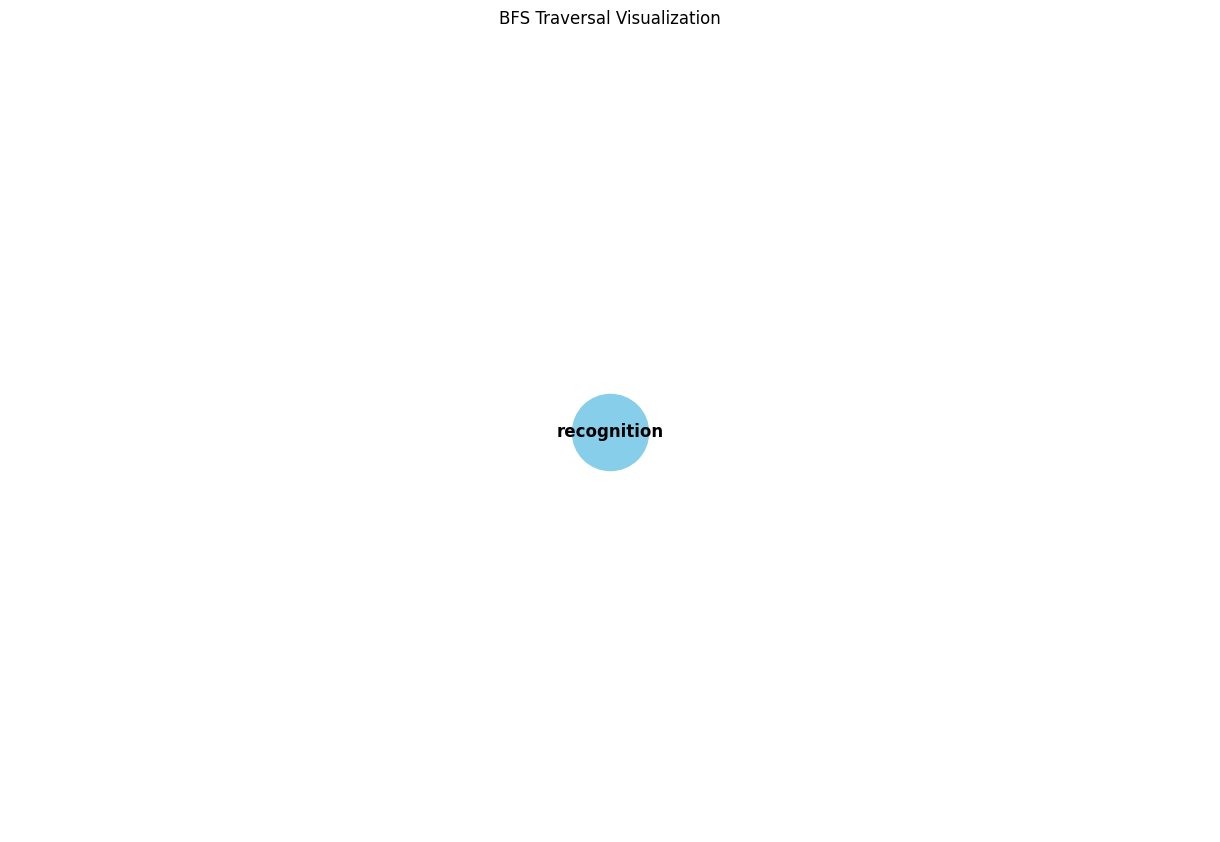

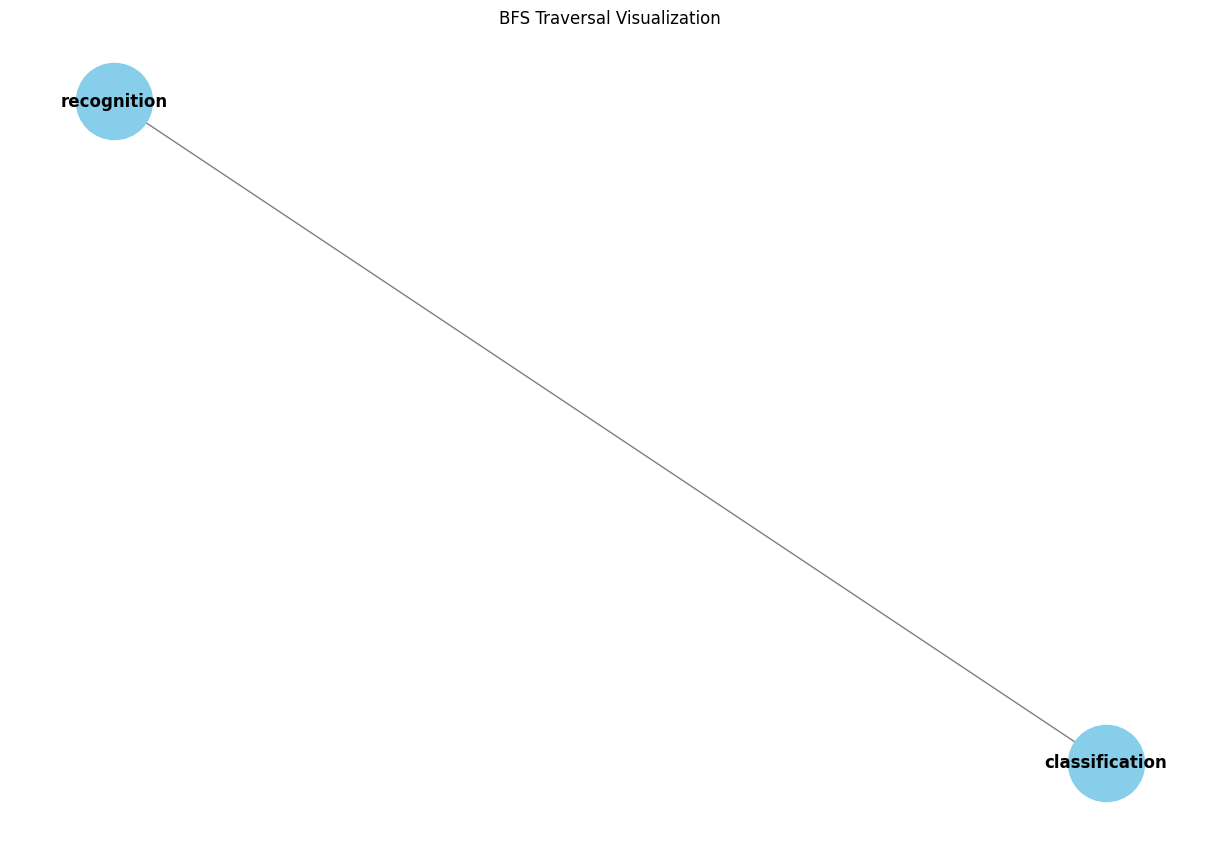

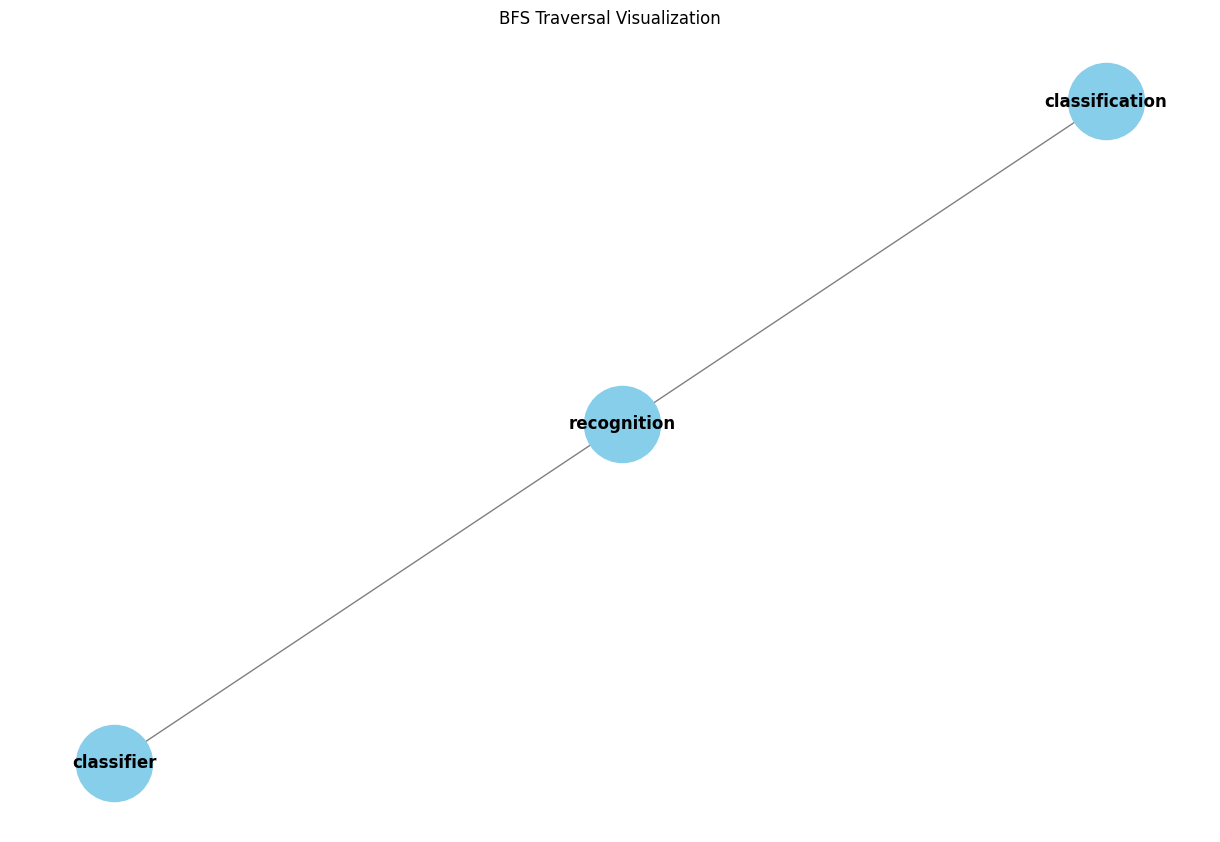

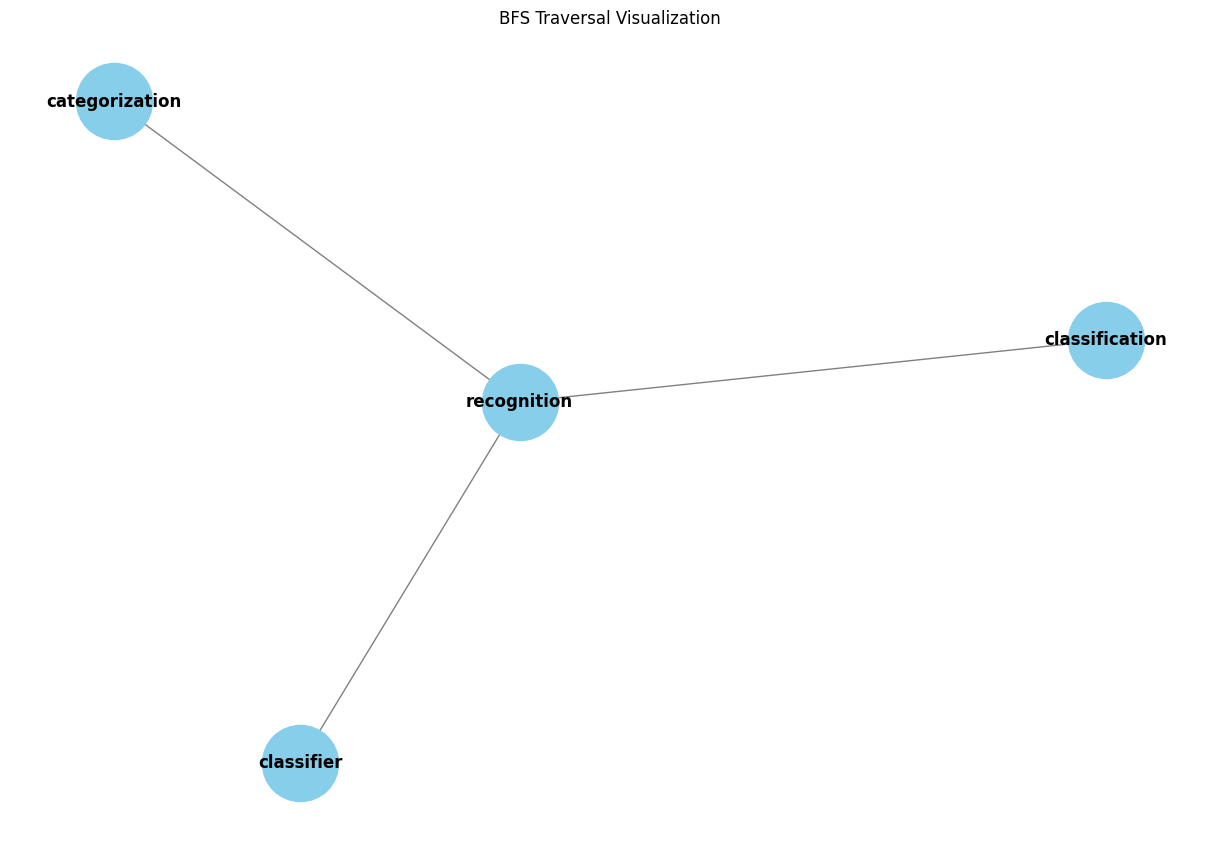

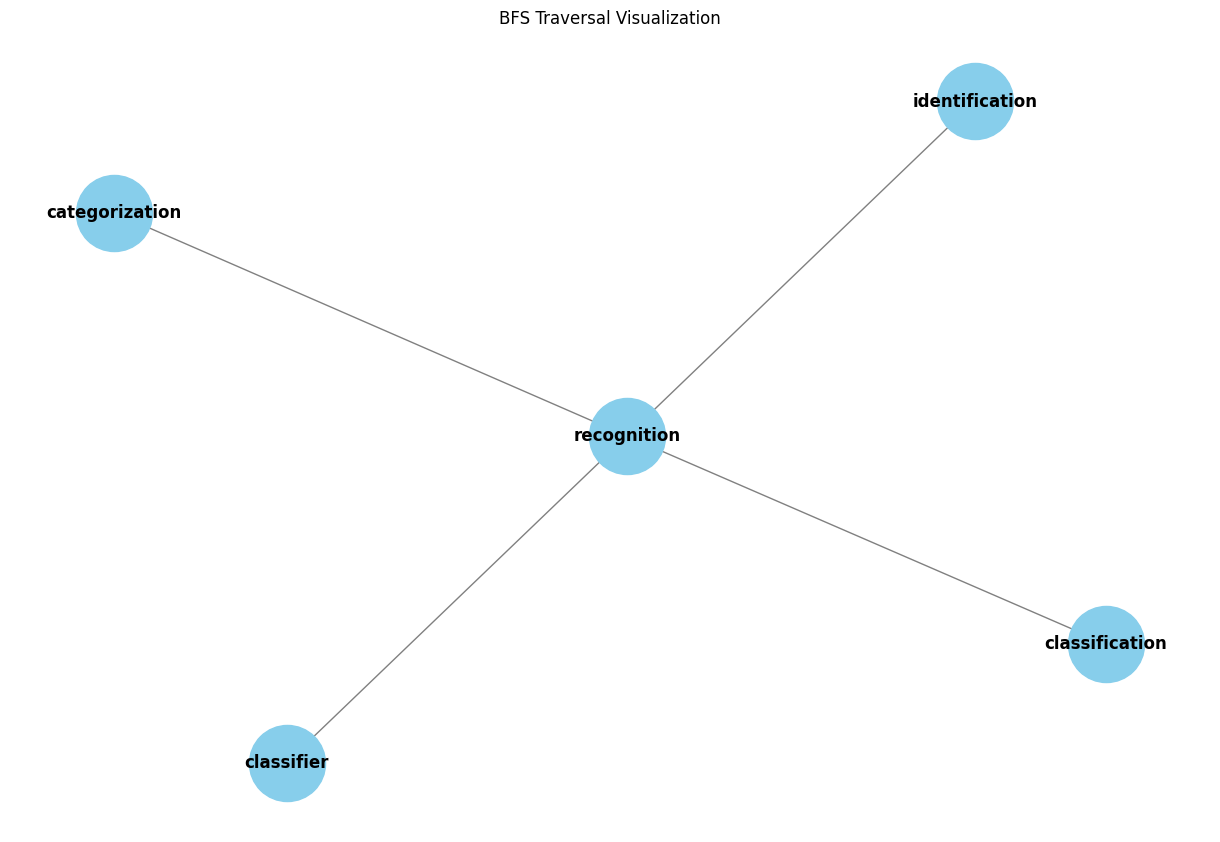

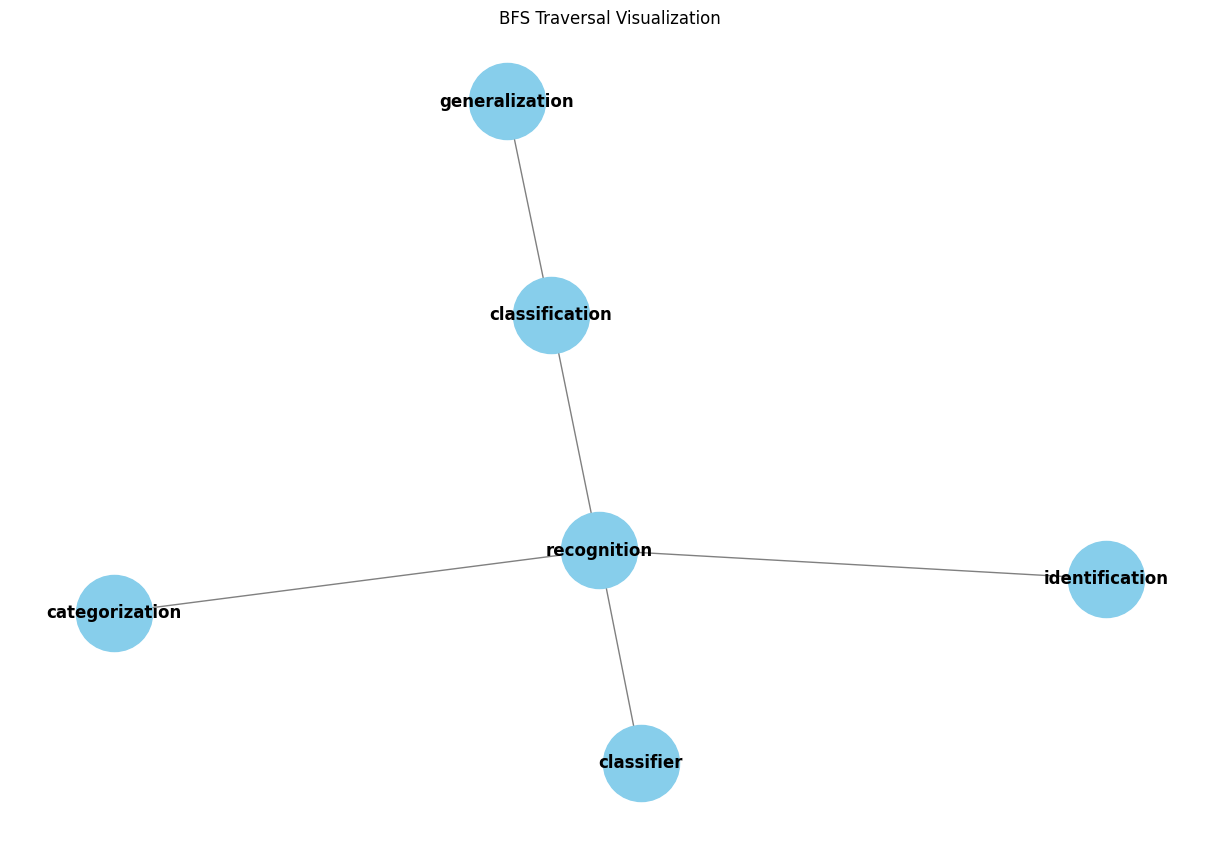

Related Keywords: ['recognition', 'classification', 'classifier', 'categorization', 'identification', 'generalization']


In [71]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import time  # To add a delay between each node visualization

class GraphTraversal:
    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
    
    def get_most_connected_node(self, bucket):
        session = self.driver.session()
        try:
            query = f"""
            MATCH (k:Keyword)-[:RELATED]->(related:Keyword)
            WHERE k.bucket = '{bucket}'
            RETURN k.name AS keyword, COUNT(related) AS connections
            ORDER BY connections DESC
            LIMIT 1
            """
            result = session.run(query)
            most_connected_node = result.single()
            if most_connected_node:
                return most_connected_node["keyword"]
            else:
                return None
        finally:
            session.close()

    def bfs_traversal(self, start_keyword, bucket, depth=3):
        session = self.driver.session()
        try:
            visited = set([start_keyword])
            queue = [start_keyword]
            related_keywords = []
            graph = nx.Graph()  # Create an empty graph for visualization

            graph.add_node(start_keyword)  # Add the starting keyword as a node in the graph

            # Visualize initial state
            self.visualize_graph(graph)

            while queue:
                current_node = queue.pop(0)
                query = f"""
                MATCH (start:Keyword {{name: '{current_node}', bucket: '{bucket}'}})-[r:RELATED]->(related:Keyword)
                RETURN related, r.weight AS weight
                ORDER BY weight DESC
                """
                result = session.run(query)

                # Create a list of neighbors sorted by weight in descending order
                sorted_neighbors = []
                for record in result:
                    related_keyword = record["related"]["name"]
                    weight = record["weight"]
                    sorted_neighbors.append((related_keyword, weight))
                
                # Add neighbors to the queue based on sorted weight order
                for related_keyword, weight in sorted_neighbors:
                    if related_keyword not in visited:
                        visited.add(related_keyword)
                        queue.append(related_keyword)
                        related_keywords.append(related_keyword)
                        graph.add_node(related_keyword)  # Add the related keyword as a node
                        graph.add_edge(current_node, related_keyword, weight=weight)  # Add an edge with the weight between nodes

                        # Visualize graph after adding a new node
                        self.visualize_graph(graph)

            return related_keywords

        finally:
            session.close()

    def visualize_graph(self, graph):
        """Visualize the graph after each node is added."""
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(graph, seed=42)  # Positioning nodes using spring layout
        nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
        plt.title(f"BFS Traversal Visualization")
        plt.show()
        time.sleep(1)  # Pause for 1 second to make the visualization step-by-step

# Initialize the GraphTraversal instance
graph_traversal = GraphTraversal(uri="bolt://localhost:7687", username="neo4j", password="akashbhumi")

# Define the bucket to work with (bucket1, bucket2, or bucket3)
bucket = 'bucket3'

# Get the most connected node in the specified bucket
start_keyword = graph_traversal.get_most_connected_node(bucket)

if start_keyword:
    print(f"Starting BFS traversal from keyword: {start_keyword}")
    bucket3_traversal_keywords = [start_keyword] + graph_traversal.bfs_traversal(start_keyword, bucket, depth=3)
    print("Related Keywords:", bucket3_traversal_keywords)
else:
    print(f"No connected nodes found in {bucket}.")


In [72]:
print(query_keyword)

machine learning


In [73]:
import json


# The query keyword
querykeyword = 'queryKeyword'

# Insert the querykeyword at the start of each bucket's list
bucket1_traversal_keywords.insert(0, query_keyword)
bucket2_traversal_keywords.insert(0, query_keyword)
bucket3_traversal_keywords.insert(0, query_keyword)

# Save each bucket to a separate JSON file
bucket_data = {
    'bucket1': bucket1_traversal_keywords,
    'bucket2': bucket2_traversal_keywords,
    'bucket3': bucket3_traversal_keywords
}

# Save each bucket to its own file
for bucket_name, keywords in bucket_data.items():
    file_name = f"{bucket_name}_keywords.json"
    with open(file_name, 'w') as json_file:
        json.dump(keywords, json_file, indent=4)
    print(f"Keywords for {bucket_name} saved to {file_name}")


Keywords for bucket1 saved to bucket1_keywords.json
Keywords for bucket2 saved to bucket2_keywords.json
Keywords for bucket3 saved to bucket3_keywords.json
